In [97]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import seaborn as sns
import math
from scipy.special import gamma as gamma_func


# == SET THE SEED FOR REPRODUCIBILITY == #
np.random.seed(42)

plt.style.use('seaborn-v0_8-whitegrid') 

latex_preamble = r"\usepackage{amsmath}"
mpl.rcParams.update({
    # Use TeX for rendering text
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],  # Replace with your preferred serif font if needed
    "text.latex.preamble" : latex_preamble,
    
    # Axes settings
    "axes.titlesize": 24,     # Font size for axes titles
    "axes.labelsize": 24,     # Font size for axes labels
    
    # Tick settings
    "xtick.labelsize": 18,    # Font size for x-axis tick labels
    "ytick.labelsize": 18,    # Font size for y-axis tick labels
    
    # Legend settings
    "legend.fontsize": 24,    # Font size for legend
    
    # Figure settings
    "figure.figsize": (16, 8), # Default figure size (width, height) in inches
    "figure.dpi": 250,        # Dots per inch
    
    # Lines
    "lines.linewidth": 2,     # Line width
    "lines.markersize": 6,    # Marker size
    
    # Grid settings
    "grid.color": "gray",     # Grid color
    "grid.linestyle": "--",   # Grid line style
    "grid.linewidth": 0.5,    # Grid line width
    "grid.alpha": 0.7,        # Grid transparency
    
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "font.weight": "bold",
})

In [98]:
# == Setting up the constants ==

def define_parameters():
    """Define parameters for the BLISS model and return as a dictionary.

    Parameters are annotated with units and descriptions based on the provided model.
    """
    params = {
        'd': 0.01, # Host cell death rate (1/day)
        'lambda': 2, # Production rate of host cells (cell/mm^3 /day)
        'beta': 0.004, # Infection rate of host cells by HIV (mmm^3/virus /day))
        'a': 0.33, # Death rate of HIV infected cells (1/day)
        'alpha': 0.004, # Infection rate by the recombinant virus (mm^3/virus /day)
        'b': 2, # Death rate of double-infected cells (1/day)
        'k': 50, # Production rate of virus by HIV infected cells (virus/cell /day)
        'u': 2, # Removal rate of HIV virus (1/day)
        'c': 2000, # Production rate of recombinant virus by double-infected cells (virus/cell /day)
        'q': 2, # Removal rate of recombinant virus (1/day)
    }
 
    return params

def compute_R_v(params):
    R_v = params['beta'] * params['lambda'] * params['k'] / (params['a'] * params['d'] * params['u'])
    return R_v

def compute_R_w(params):
    R_w = (params['alpha'] * params['lambda'] * params['c'] / (params['a'] * params['b'] * params['q'])) * (compute_R_v(params) - 1) / compute_R_v(params)
    return R_w

# == Setting up the initial conditions ==

# Initial values
initial_conditions_single_infection = [
    200, # Initial host cells - x
    0, # Initial infected cells - y
    1e-6 # Initial virus (a few hundred viruses in the whole body) - v
]

initial_conditions_double_infection = [
    3, # Initial host cells - x
    6, # Initial infected cells - y,
    0, # Initial double-infected cells - z
    149, # Initial virus - v
    1 # Initial recombinant virus - w
]

initial_conditions_single_infection = np.array(initial_conditions_single_infection)
initial_conditions_double_infection = np.array(initial_conditions_double_infection)

# == Setup equilibrium points ==

def no_infection_equilibrium(params):
    p = [params['lambda']/params['d'], 0, 0, 0, 0]
    return np.array(p)

def single_infection_equilibrium(params):
    a = params['a']
    u = params['u']
    beta = params['beta']
    k = params['k']
    lambda_p = params['lambda']
    d = params['d']

    p = [a*u/(beta*k), lambda_p/a - (d*u)/(beta*k), 0, lambda_p * k / (a*u) - d/beta, 0]
    return np.array(p)

def double_infection_equilibrium(params):
    a = params['a']
    u = params['u']
    beta = params['beta']
    k = params['k']
    lambda_p = params['lambda']
    d = params['d']
    alpha = params['alpha']
    c = params['c']
    b = params['b']
    q = params['q']

    x_3 = lambda_p /(d+beta*b*k*q/(alpha*c*u))
    y_3 = b*q/(alpha*c)
    v_3 = b*q*k/(alpha*c*u)
    w_3 = (alpha*beta*lambda_p*c*k - beta*a*b*k*q - alpha*a*c*d*u)/(alpha*(beta*b*k*q + alpha*c*d*u))
    z_3 = (q/c)*w_3

    p = [x_3, y_3, z_3, v_3, w_3]
    return np.array(p)

# == Setting up the ODE systems ==

def single_infection_system(t, y, params):
    dy = np.zeros_like(y)
    x, y, v = y

    lambda_p = params['lambda']
    d = params['d']
    beta = params['beta']
    a = params['a']
    k = params['k']
    u = params['u']

    dxdt = lambda_p - d*x - beta*x*v
    dydt = beta*x*v - a*y
    dvdt = k*y - u*v

    dy[0] = dxdt
    dy[1] = dydt
    dy[2] = dvdt

    return dy

def double_infection_system(t,y,params):
    dy = np.zeros_like(y)
    x, y, z, v, w = y

    lambda_p = params['lambda']
    d = params['d']
    beta = params['beta']
    a = params['a']
    b = params['b']
    k = params['k']
    u = params['u']
    alpha = params['alpha']
    c = params['c']
    q = params['q']

    dxdt = lambda_p - d*x - beta*x*v
    dydt = beta*x*v - a*y - alpha*w*y
    dzdt = alpha*w*y - b*z
    dvdt = k*y - u*v
    dwdt = c*z - q*w

    dy[0] = dxdt
    dy[1] = dydt
    dy[2] = dzdt
    dy[3] = dvdt
    dy[4] = dwdt

    return dy


y_ticks = [0.1, 1, 10, 100, 1000]
y_lim = [1e-2, 1e4]
dt = 0.1

In [99]:
# == Figure \label{fig:lot_of_different_CI} ==

# -- Setup the figure -- #

params = define_parameters()
params['alpha'] = 4 * params['beta'] # we use the case alpha = 4*beta for a nicer figure
n_simulation = 5 # TODO: Change to 500 for the final figure
T = 90
time = np.arange(0, T*2, dt)

values_90 = []
values_180 = []

# -- Run the simulations -- #

initial_conditions_double_infection_verification = []
for i in range(n_simulation):
    sampled_values = double_infection_equilibrium(params) + np.random.uniform(-0.5, 0.5, 5) * double_infection_equilibrium(params) * 2.5
    sampled_values[0] = np.maximum(sampled_values[0], 1)  # Enforce no negative values
    sampled_values[1] = np.maximum(sampled_values[1], 1)  # Enforce no negative values
    sampled_values = np.maximum(sampled_values, 1e-3)  # Enforce no negative values
    initial_conditions_double_infection_verification.append(sampled_values)

initial_conditions_double_infection_verification = np.array(initial_conditions_double_infection_verification)

# -- Plot the results -- #

fig, ax = plt.subplots(figsize=(16, 8))

equilibrium_values = double_infection_equilibrium(params)

for i in tqdm(range(initial_conditions_double_infection_verification.shape[0])):
    solution_double_infection = solve_ivp(
        fun=lambda t, y: double_infection_system(t, y, params),
        t_span=(0, T*2),
        y0=initial_conditions_double_infection_verification[i],
        t_eval=time,
        method='BDF',
        rtol=1e-6,
        max_step=dt
    )

    # Store the v values at T = 90 and T = 180
    values_90.append(solution_double_infection.y[3][int(T/dt)])
    values_180.append(solution_double_infection.y[3][-1])

    # keep and plot the solution only until T
    solution_double_infection.t = solution_double_infection.t[:len(solution_double_infection.t)//2]
    solution_double_infection.y = [y[:len(y)//2] for y in solution_double_infection.y]

    ax.plot(solution_double_infection.t, solution_double_infection.y[3], alpha=0.35, linewidth=2)

ax.axhline(double_infection_equilibrium(params)[3], color='r', linestyle='--', label=r'$v_3^*$')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Density (count/mm$^3$)')
ax.set_yscale('log')
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(y_lim)
ax.set_xlim([0, T])
ax.legend()
plt.tight_layout()

# save the figure in pdf format
plt.savefig('lot_of_different_CI.pdf', format='pdf', bbox_inches='tight')

plt.show()    

# == Figure \label{fig:boxplot_percent_error} ==

# -- Computation of the error distributions at T = 90 (half the simulation) and T = 180 (end of the simulation) -- #

errors_90 = []
errors_180 = []

for i in range(initial_conditions_double_infection.shape[0]):
    errors_90.append((values_90[i] - equilibrium_values[3]) / equilibrium_values[3]) 
    errors_180.append((values_180[i] - equilibrium_values[3]) / equilibrium_values[3])

errors_90 = np.array(errors_90) * 100
errors_180 = np.array(errors_180) * 100

# -- Plot the boxplot -- #

fig, ax = plt.subplots(figsize=(16, 4))
ax.boxplot([errors_90, errors_180], tick_labels=['T = 90', 'T = 180'], showmeans=True, vert=False) 
ax.set_xlabel(r"Relative error $(\%) : e_{v_{3}}(t=T) = \frac{v_3(t = T) - v_3^*}{v_3^*} \times 100$")
ax.invert_yaxis()
plt.tight_layout()

# save the figure in pdf format
plt.savefig('boxplot_percent_error.pdf', format='pdf', bbox_inches='tight')

plt.show()

100%|██████████| 5/5 [00:01<00:00,  4.34it/s]


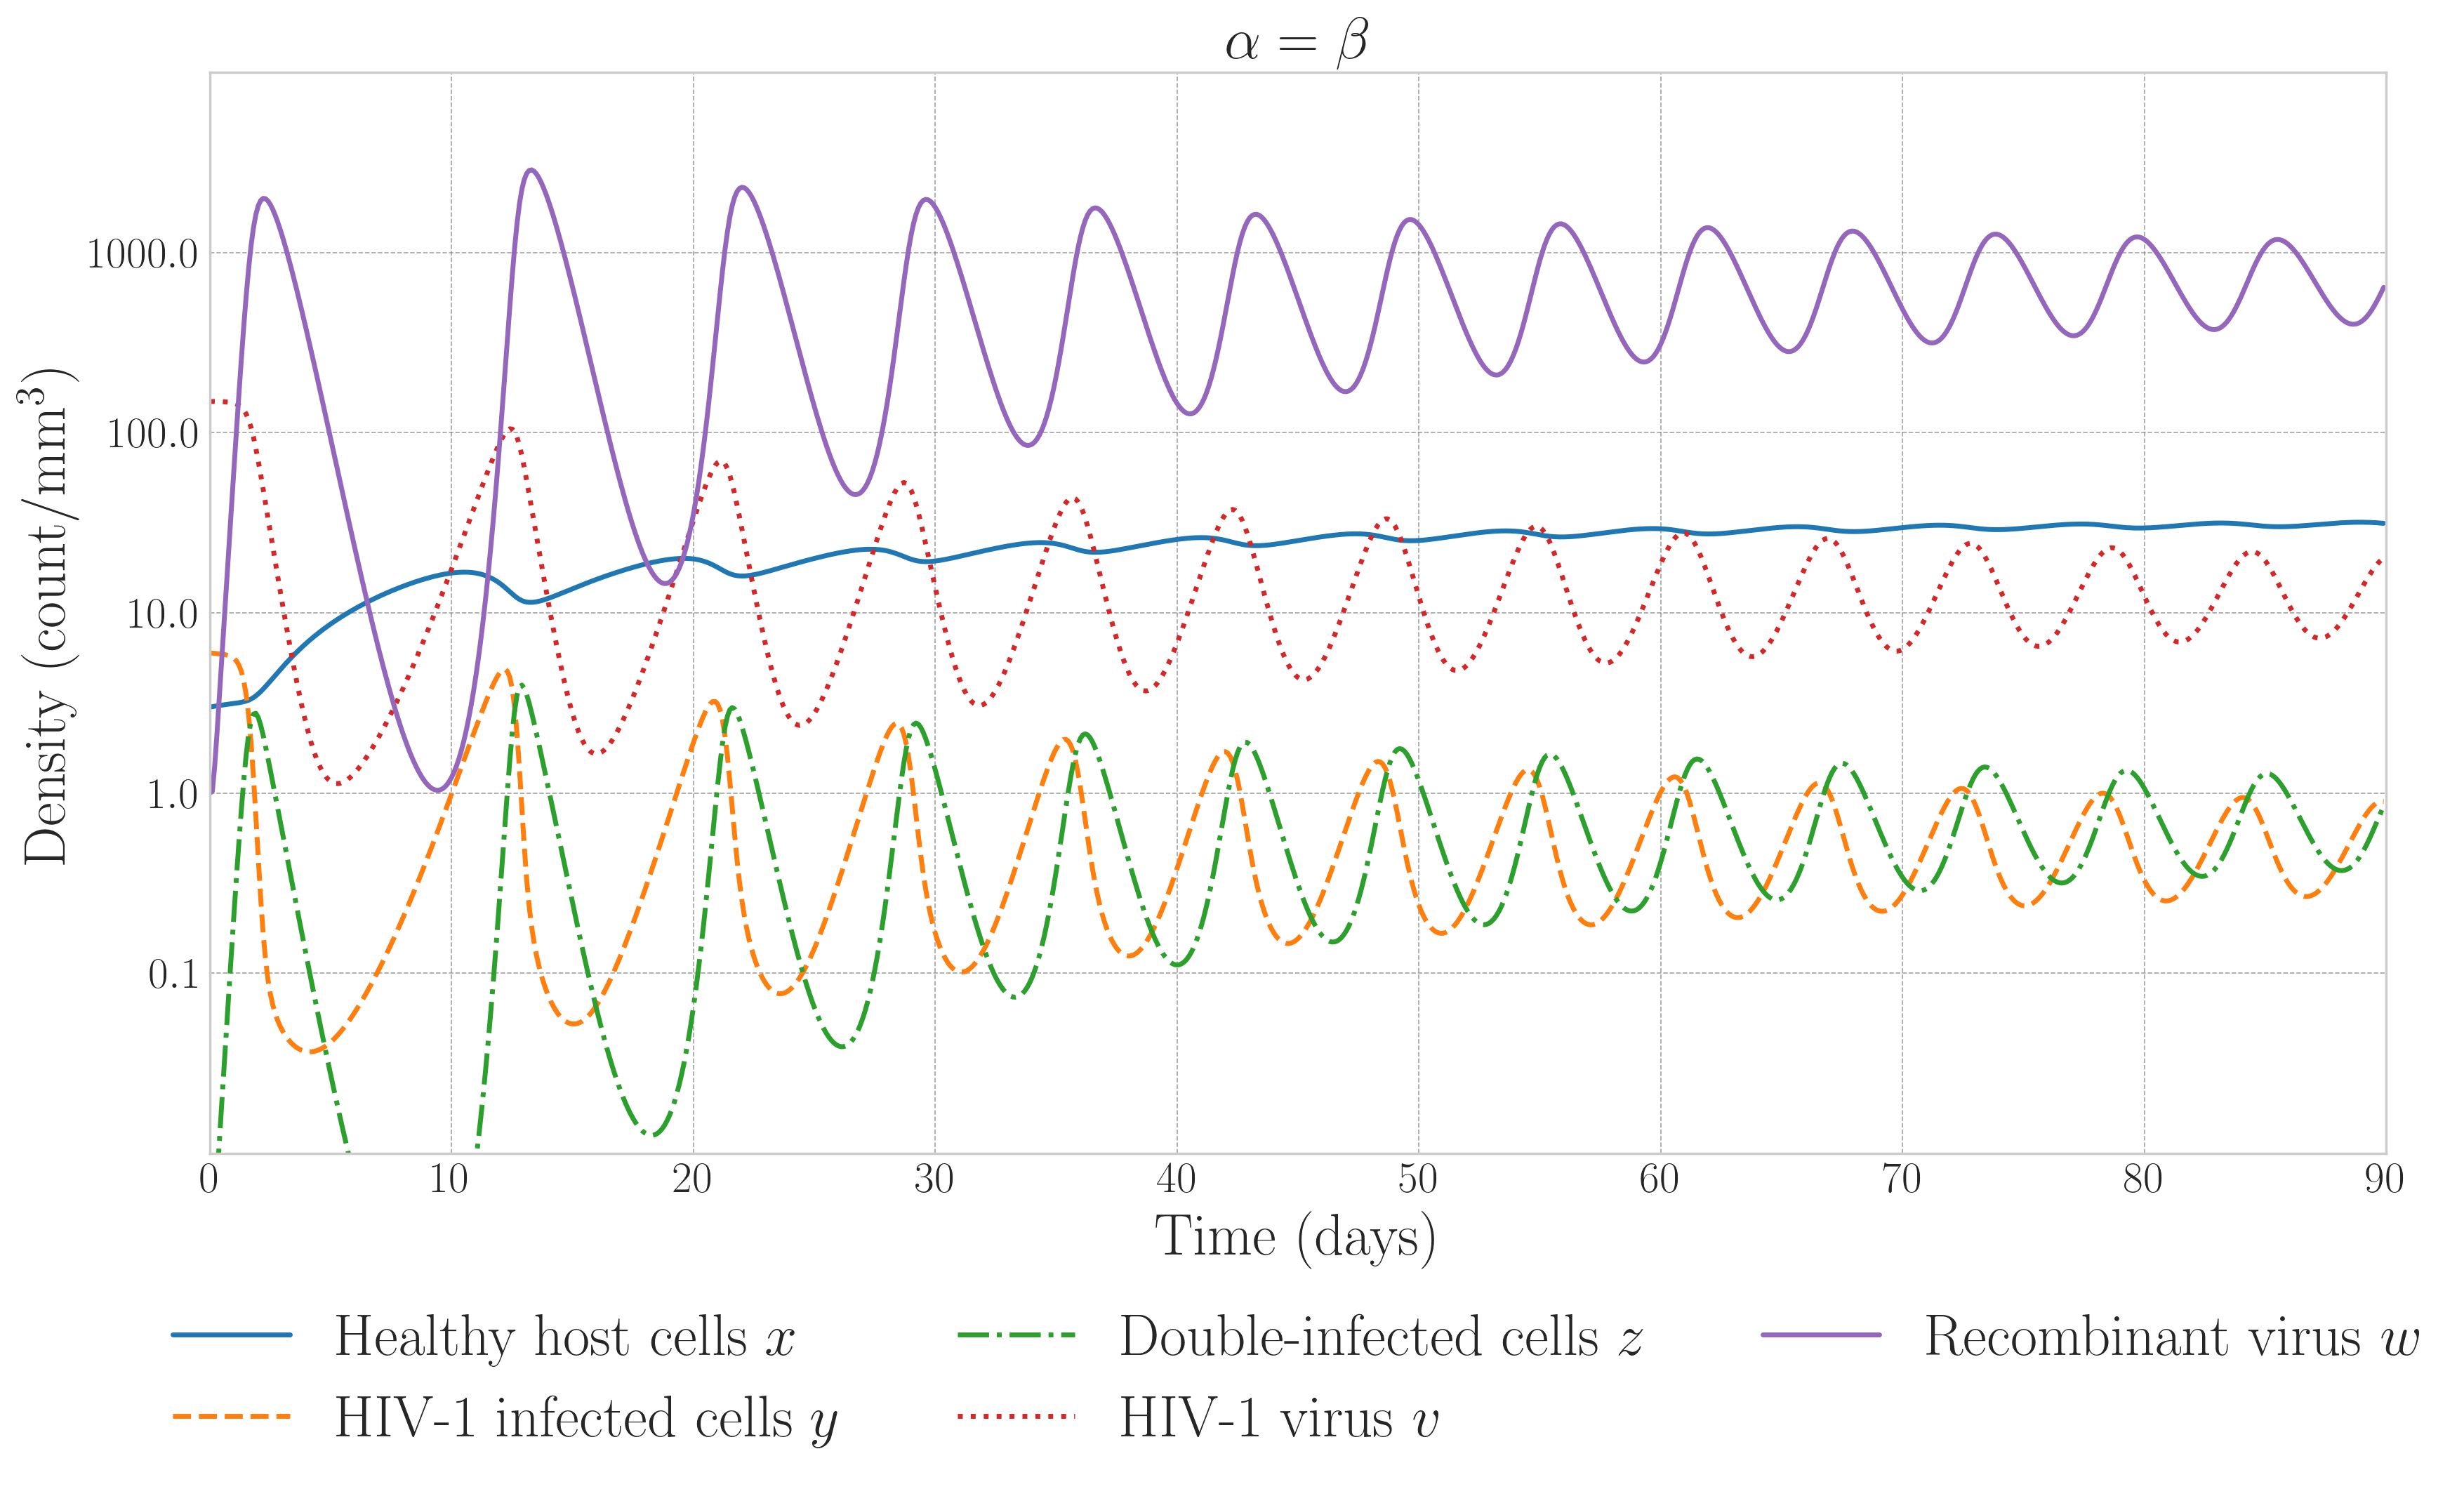

In [100]:
# == Figure \label{fig:single_infection} ==
# -- Setup the figure -- #

params = define_parameters()
T = 90
time = np.arange(0, T, dt)
u0 = np.asarray(initial_conditions_single_infection)

# -- Run the simulation -- #

solution_single_infection = solve_ivp(
    fun=lambda t, y: single_infection_system(t, y, params),
    t_span=(0, T),
    y0=u0,
    t_eval=time,
    method='BDF',
    rtol=1e-6,
    max_step=dt
)

# -- Plot the results -- #

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(solution_single_infection.t, solution_single_infection.y[0], label=r'Healthy host cells $x$')
ax.plot(solution_single_infection.t, solution_single_infection.y[1], label=r'HIV-1 infected cells $y$', linestyle='--')
ax.plot(solution_single_infection.t, solution_single_infection.y[2], label=r'free HIV-1 virus $v$', linestyle='-.')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Density (count/mm$^3$)')
ax.set_yscale('log')
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(y_lim)
ax.set_xlim([0, T])
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)

# save the figure in pdf format
plt.savefig('single_infection.pdf', format='pdf', bbox_inches='tight')

plt.show()

# == Figure \label{fig:double_infection} ==

# -- Setup the figure -- #

params = define_parameters()
T = 90
time = np.arange(0, T, dt)
u0 = np.asarray(initial_conditions_double_infection)

# -- Run the simulation -- #

solution_double_infection = solve_ivp(
    fun=lambda t, y: double_infection_system(t, y, params),
    t_span=(0, T),
    y0=u0,
    t_eval=time,
    method='BDF',
    rtol=1e-6,
    max_step=dt
)

# -- Plot the results -- #

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(solution_double_infection.t, solution_double_infection.y[0], label=r'Healthy host cells $x$')
ax.plot(solution_double_infection.t, solution_double_infection.y[1], label=r'HIV-1 infected cells $y$', linestyle='--')
ax.plot(solution_double_infection.t, solution_double_infection.y[2], label=r'Double-infected cells $z$', linestyle='-.')
ax.plot(solution_double_infection.t, solution_double_infection.y[3], label=r'HIV-1 virus $v$', linestyle=':')
ax.plot(solution_double_infection.t, solution_double_infection.y[4], label=r'Recombinant virus $w$', linestyle='-')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Density (count/mm$^3$)')
ax.set_yscale('log')
ax.set_yticks(y_ticks)
ax.set_xlim([0, T])

ax.set_title(r"$\alpha = \beta$")

ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(y_lim)
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
# save the figure in pdf format
plt.savefig('double_infection.pdf', format='pdf', bbox_inches='tight')

plt.show()

# == Figure \label{fig:double_infection_2} ==
# -- Setup the figure -- #

params = define_parameters()
params['alpha'] = 4 * params['beta'] # we use the case alpha = 4*beta
T = 90
time = np.arange(0, T, dt)
u0 = np.asarray(initial_conditions_double_infection)

# -- Run the simulation -- #

solution_double_infection = solve_ivp(
    fun=lambda t, y: double_infection_system(t, y, params),
    t_span=(0, T),
    y0=u0,
    t_eval=time,
    method='BDF',
    rtol=1e-6,
    max_step=dt
)

# -- Plot the results -- #

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(solution_double_infection.t, solution_double_infection.y[0], label=r'Healthy host cells $x$')
ax.plot(solution_double_infection.t, solution_double_infection.y[1], label=r'HIV-1 infected cells $y$', linestyle='--')
ax.plot(solution_double_infection.t, solution_double_infection.y[2], label=r'Double-infected cells $z$', linestyle='-.')
ax.plot(solution_double_infection.t, solution_double_infection.y[3], label=r'HIV-1 virus $v$', linestyle=':')
ax.plot(solution_double_infection.t, solution_double_infection.y[4], label=r'Recombinant virus $w$', linestyle='-')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Density (count/mm$^3$)')
ax.set_yscale('log')
ax.set_yticks(y_ticks)
ax.set_xlim([0, T])

ax.set_title(r"$\alpha = 4\beta$")

ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(y_lim)
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
# save the figure in pdf format
plt.savefig('double_infection_2.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [101]:
# == Figure \label{fig:beta_alpha_c} ==
"""The goal of this figure is to show the bifurcation of the system when the parameter $c$ is varied and this, for beta = alpha = 0.004. and also for 
alpha = 4*beta = 0.016 (on the same figure). We simulate the model for $c$ in the range [500, 1e4] (using a log scale) and we plot the density of free HIV-1 virus at T = 200 days.
Because we can have oscillations in the system, we look at the maximum value and the minimum value of the density of free HIV-1 virus between T = 225 and T = 200 days. If the 
difference between the maximum and the minimum is greater than 1e-1, we consider that the system oscillates. 
If oscillations are present, we plot the maximum and minimum values of the density of free HIV-1 virus between T = 225 and T = 200 days.
If oscillations are not present, we plot the density of free HIV-1 virus at T = 200 days.
-> scatter plot
"""

# -- Setup the figure -- #
T = 200
time = np.arange(0, T, dt)
n_simulation = 5
c_max = 1e5

# Initialize arrays for beta = alpha
c_min_alpha = 500
c_values_alpha = np.logspace(np.log10(c_min_alpha), np.log10(c_max), n_simulation)
v_max_alpha = np.zeros(n_simulation)
v_min_alpha = np.zeros(n_simulation)
v_200_alpha = np.zeros(n_simulation)
oscillations_alpha = np.zeros(n_simulation)

# Initialize arrays for alpha = 4 * beta
c_min_4alpha = 225
c_values_4alpha = np.logspace(np.log10(c_min_4alpha), np.log10(c_max), n_simulation)
v_max_4alpha = np.zeros(n_simulation)
v_min_4alpha = np.zeros(n_simulation)
v_200_4alpha = np.zeros(n_simulation)
oscillations_4alpha = np.zeros(n_simulation)

params = define_parameters()
params['beta'] = 0.004

# -- Run the simulations for beta = alpha -- #
params['alpha'] = 0.004
for i in tqdm(range(n_simulation)):
    params['c'] = c_values_alpha[i]
    solution_double_infection = solve_ivp(
        fun=lambda t, y: double_infection_system(t, y, params),
        t_span=(0, T),
        y0=initial_conditions_double_infection,
        t_eval=time,
        method='BDF',
        rtol=1e-6,
        max_step=dt
    )

    v_max_alpha[i] = np.max(solution_double_infection.y[3][int(150/dt):])
    v_min_alpha[i] = np.min(solution_double_infection.y[3][int(150/dt):])
    v_200_alpha[i] = solution_double_infection.y[3][-1]
    oscillations_alpha[i] = v_max_alpha[i] - v_min_alpha[i]

# -- Run the simulations for alpha = 4 * beta -- #
params['alpha'] = 4 * params['beta']
for i in tqdm(range(n_simulation)):
    params['c'] = c_values_4alpha[i]
    solution_double_infection = solve_ivp(
        fun=lambda t, y: double_infection_system(t, y, params),
        t_span=(0, T),
        y0=initial_conditions_double_infection,
        t_eval=time,
        method='BDF',
        rtol=1e-6,
        max_step=dt
    )

    v_max_4alpha[i] = np.max(solution_double_infection.y[3][int(150/dt):])
    v_min_4alpha[i] = np.min(solution_double_infection.y[3][int(150/dt):])
    v_200_4alpha[i] = solution_double_infection.y[3][-1]
    oscillations_4alpha[i] = v_max_4alpha[i] - v_min_4alpha[i]

# -- Plot the results -- #
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the oscillations for beta = alpha
# Plot the oscillations for $\alpha = 4 \beta$
mask_4alpha = oscillations_4alpha > 1e-1
mask_alpha = oscillations_alpha > 1e-1
ax.plot(c_values_alpha[mask_alpha], v_max_alpha[mask_alpha], label=r'Maximum $v$ ($\beta = \alpha$)', linestyle='-')
ax.plot(c_values_4alpha[mask_4alpha], v_max_4alpha[mask_4alpha], label=r'Maximum $v$ ($\alpha = 4\beta$)', linestyle='--')
ax.plot(c_values_alpha[mask_alpha], v_min_alpha[mask_alpha], label=r'Minimum $v$ ($\beta = \alpha$)', linestyle='-')
ax.plot(c_values_4alpha[mask_4alpha], v_min_4alpha[mask_4alpha], label=r'Minimum $v$ ($\alpha = 4\beta$)', linestyle='--')
# no oscillations
ax.plot(c_values_alpha[~mask_alpha], v_200_alpha[~mask_alpha], label=r'$v_3^*$($\beta = \alpha$)', linestyle='-')
ax.plot(c_values_4alpha[~mask_4alpha], v_200_4alpha[~mask_4alpha], label=r'$v_3^*$ ($\alpha = 4\beta$)', linestyle='--')

ax.set_xscale('log')
ax.set_xlabel(r'Recombinant production rate $c$')
ax.set_ylabel(r'Density (count/mm$^3$)')
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
# x lim between 100 and 1e6
ax.set_xlim([100, 1e5])
# save the figure in pdf format
plt.savefig('beta_alpha_c.pdf', format='pdf', bbox_inches='tight')

plt.show()


100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


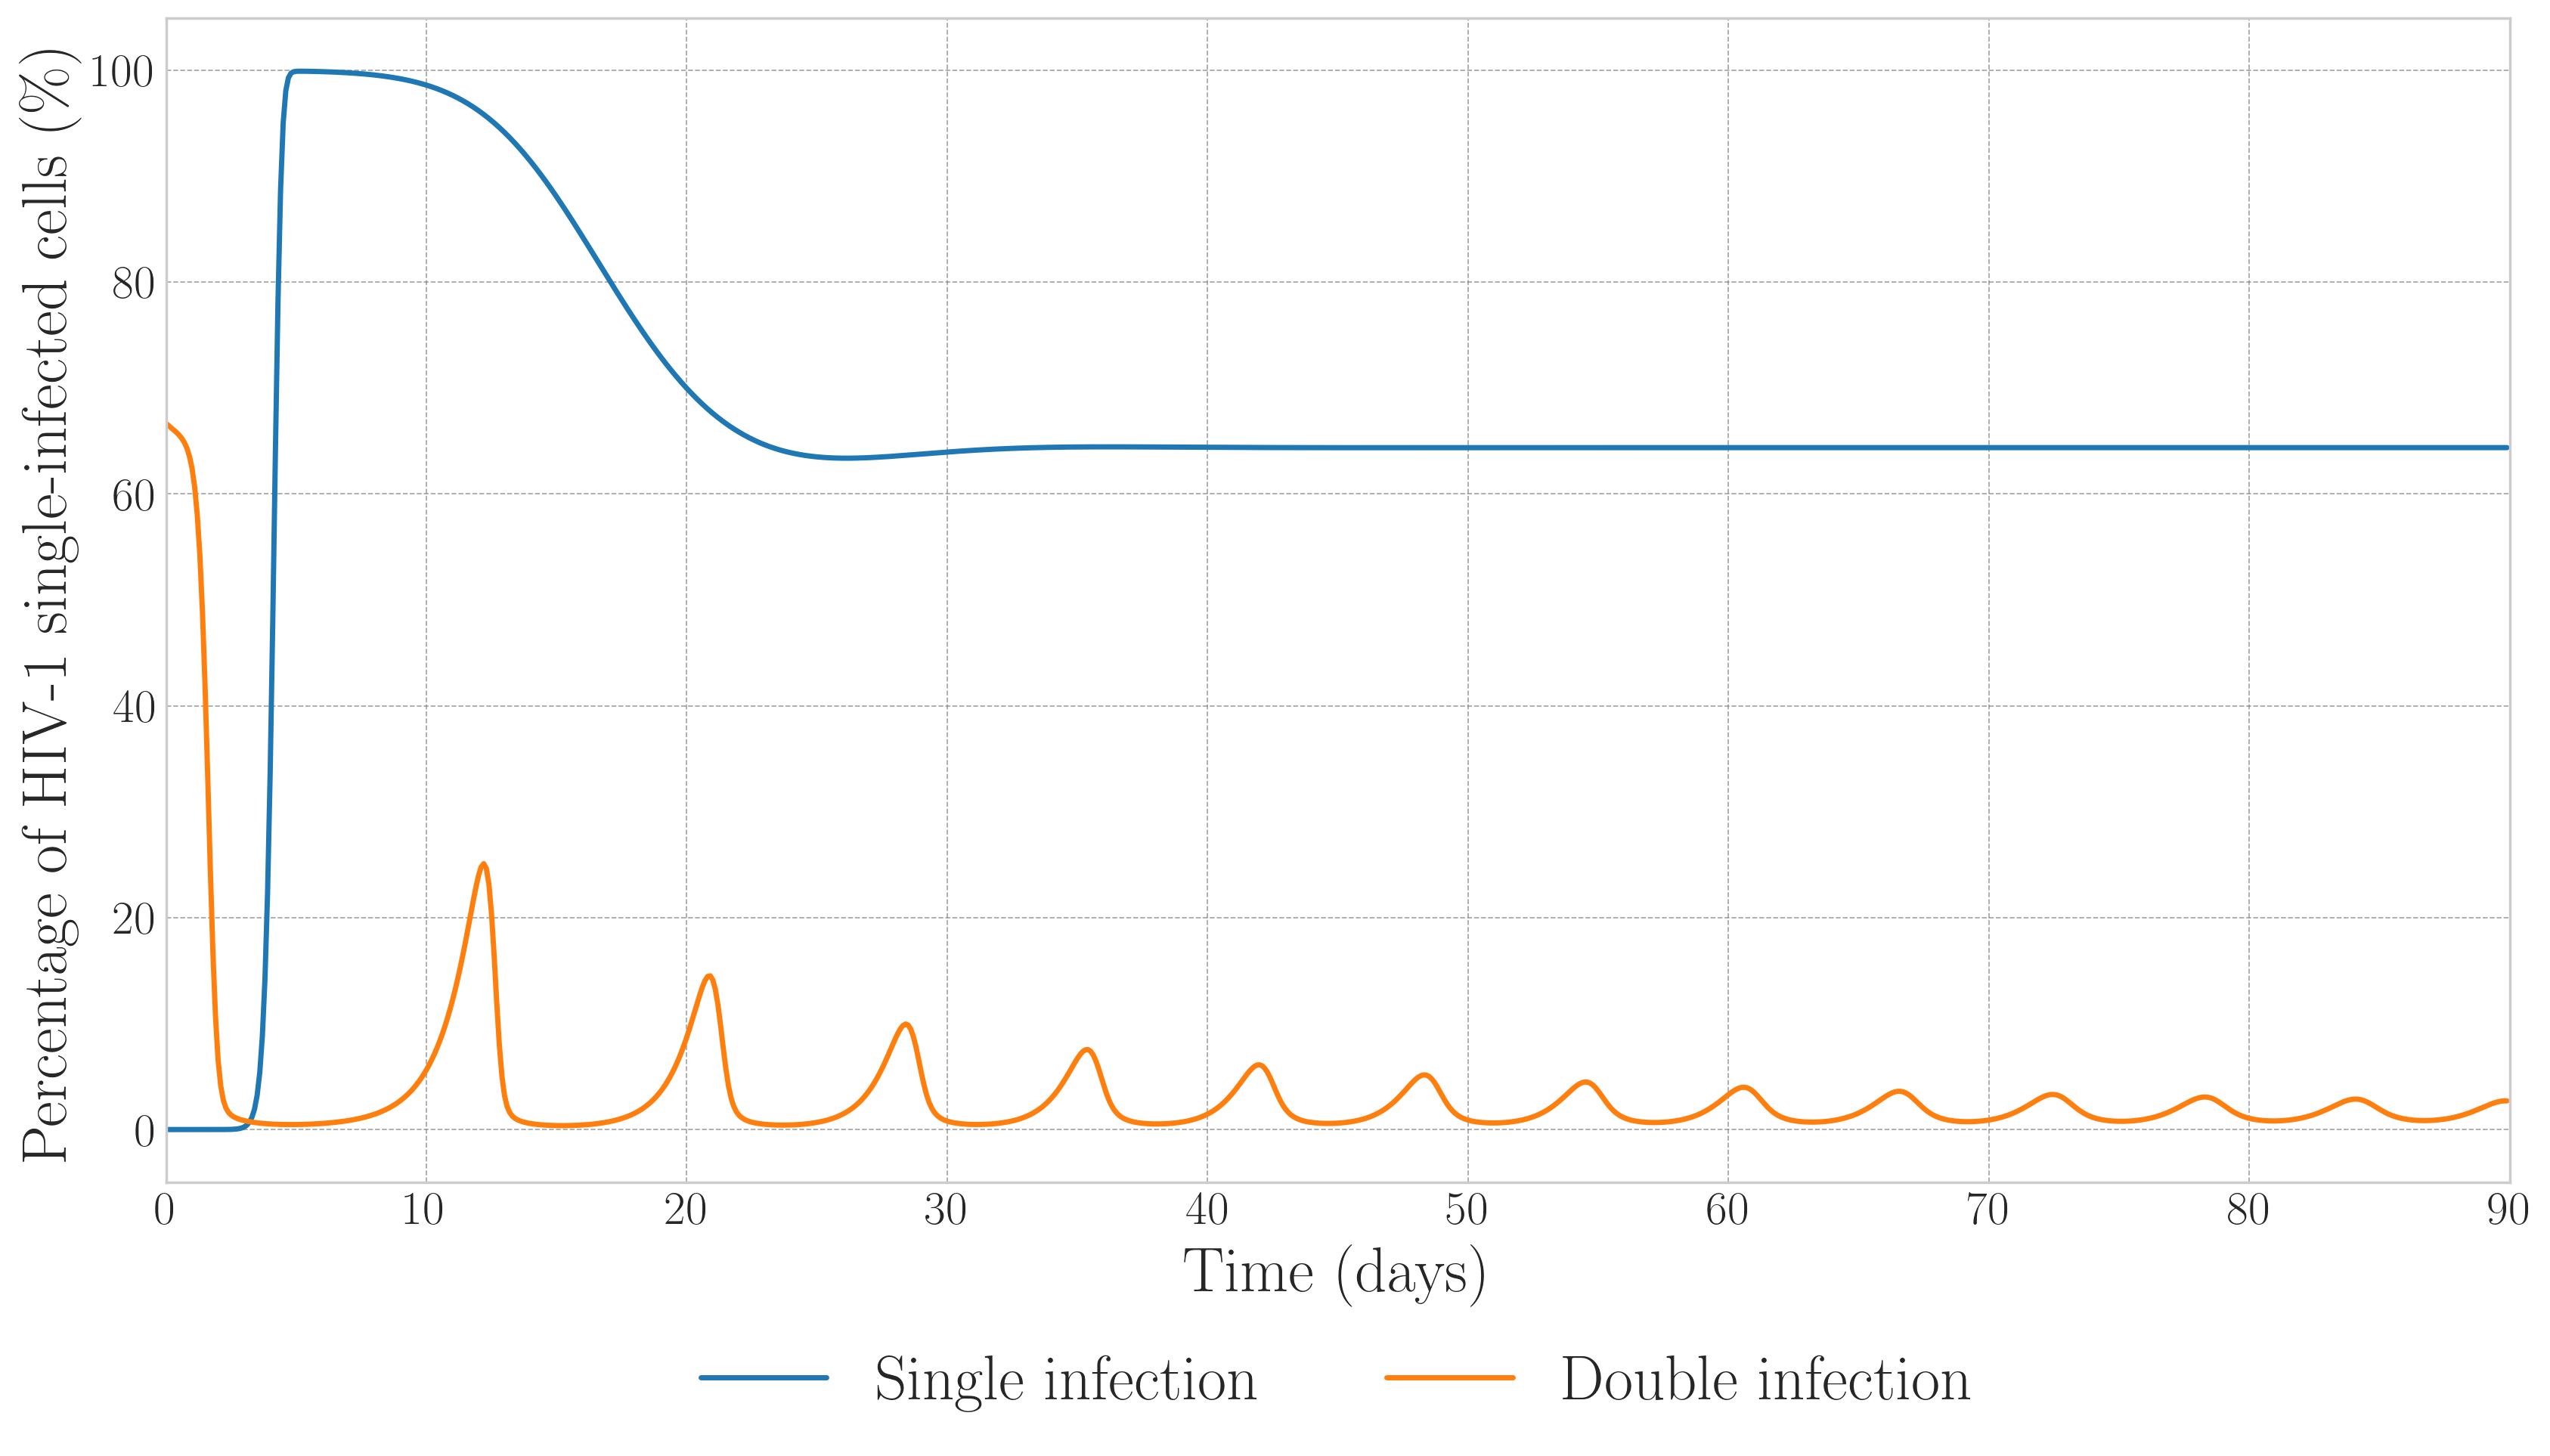

In [102]:
# == Figure \label{fig:percent_hiv_cells} ==
# percentage of cells that are y in the single cell infection (/(x+y)) and in the double infection (/(x+y+z)) for beta = alpha = 0.004 for T = 90 days
# -- Setup the figure -- #
T = 90
time = np.arange(0, T, dt)
u0_single_infection = np.asarray(initial_conditions_single_infection)
u0_double_infection = np.asarray(initial_conditions_double_infection)

# -- Run the simulations -- #
params = define_parameters()
params['beta'] = 0.004
params['alpha'] = 0.004

solution_single_infection = solve_ivp(
    fun=lambda t, y: single_infection_system(t, y, params),
    t_span=(0, T),
    y0=u0_single_infection,
    t_eval=time,
    method='BDF',
    rtol=1e-6,
    max_step=dt
)

solution_double_infection = solve_ivp(
    fun=lambda t, y: double_infection_system(t, y, params),
    t_span=(0, T),
    y0=u0_double_infection,
    t_eval=time,
    method='BDF',
    rtol=1e-6,
    max_step=dt
)

# -- Plot the results -- #
fig, ax = plt.subplots(figsize=(16, 8))

percentage_single_infection = solution_single_infection.y[1] / (solution_single_infection.y[0] + solution_single_infection.y[1])
percentage_double_infection = solution_double_infection.y[1] / (solution_double_infection.y[0] + solution_double_infection.y[1] + solution_double_infection.y[2])

ax.plot(solution_single_infection.t, percentage_single_infection * 100, label=r'Single infection')
ax.plot(solution_double_infection.t, percentage_double_infection * 100, label=r'Double infection')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Percentage of HIV-1 single-infected cells (\%)')
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2)
ax.set_xlim([0, T])
# save the figure in pdf format
plt.savefig('percent_hiv_cells.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [103]:
# == Figure \label{fig:SA} ==
"""
Perform a sensitivity analysis of the model with respect to all the parameters. We use the Sobol indices (first order) and Saltelli indices (total indices) to quantify the sensitivity of the model to each parameter.
Using SAlib, N = 2^9. Not simulating the model, directly relying on the equilibrium points to compute xi and eta.

xi = x_3^* / x_2^*
eta = v_3^* / v_2^*

We then compute the Sobol and Saltelli indices.
"""

# -- Setup the figure -- #
import SALib.sample.saltelli as sample_sobol
import SALib.analyze.sobol as sobol_analysis
import numpy as np
from tqdm import tqdm  # Import tqdm for the progress bar
import matplotlib.pyplot as plt

N = 2**2 # chaneg to 17 TODO
print(N)

# Define the problem: variables and their bounds
problem = {
    'num_vars': 10,
    'names': ['d', 'lambda', 'beta', 'a', 'alpha', 'b', 'k', 'u', 'c', 'q'],
    'bounds': [
        [0.001, 0.1],   # d
        [1, 3],         # lambda
        [0.0027, 0.007], # beta
        [0.3, 0.5],     # a
        [0.001, 0.16],  # alpha
        [0.2, 20],      # b
        [30, 120],      # k
        [1, 3],         # u
        [1000, 10000],  # c
        [1, 3]          # q
    ]
}

# Generate the Sobol samples
param_values = sample_sobol.sample(problem, N, calc_second_order=False)

print("Normal samples: ", param_values.shape)


# -- preprocessing the data by replacing any set that lead to R_v < 1 or R_w < 1; replacement by naive uniform sampling -- #

print("Preprocessing the data...")
for i in tqdm(range(param_values.shape[0])):
    p = dict(zip(problem['names'], param_values[i]))
    R_v = compute_R_v(p)
    R_w = compute_R_w(p)

    while R_v < 1 or R_w < 1:
        param_values[i] = sample_sobol.sample(problem, 2, calc_second_order=False)[0]
        p = dict(zip(problem['names'], param_values[i]))
        R_v = compute_R_v(p)
        R_w = compute_R_w(p)

print("Preprocessing done.")

def model(X):
    d, lambda_, beta, a, alpha, b, k, u, c, q = X

    p = {'d': d, 'lambda': lambda_, 'beta': beta, 'a': a, 'alpha': alpha, 'b': b, 'k': k, 'u': u, 'c': c, 'q': q}
    d_ep = double_infection_equilibrium(p)
    s_ep = single_infection_equilibrium(p)

    xi = d_ep[1] / s_ep[1]
    eta = d_ep[3] / s_ep[3]

    return xi, eta

# -- Compute the Sobol and Saltelli indices -- 
xi_values = []
eta_values = []

# Loop through the samples and compute xi and eta
for s in tqdm(param_values, desc="Computing Model Outputs", unit="sample"):
    xi, eta = model(s)
    xi_values.append(xi)
    eta_values.append(eta)

xi_values = np.array(xi_values)
eta_values = np.array(eta_values)

# Check that the number of xi and eta values matches the number of samples
print(f"Number of xi values: {xi_values.shape[0]}")
print(f"Number of eta values: {eta_values.shape[0]}")
# Perform the Sobol analysis for both xi and eta
sobol_results_xi = sobol_analysis.analyze(problem, xi_values, print_to_console=False, calc_second_order=False)
sobol_results_eta = sobol_analysis.analyze(problem, eta_values, print_to_console=False, calc_second_order=False)
# -- Plot the results using a bar chart -- #
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first order Sobol indices for xi and eta side by side
width = 0.35  # the width of the bars
x = np.arange(len(problem['names']))  # the label locations

# Define the parameter names with LaTeX symbols
param_names = [r'$d$', r'$\lambda$', r'$\beta$', r'$a$', r'$\alpha$', r'$b$', r'$k$', r'$u$', r'$c$', r'$q$']

ax[0].barh(x - width/2, sobol_results_xi['S1'], width, xerr=sobol_results_xi['S1_conf'], capsize=5, label=r'$S_i^\xi$')
ax[0].barh(x + width/2, sobol_results_eta['S1'], width, xerr=sobol_results_eta['S1_conf'], capsize=5, label=r'$S_i^\eta$')
ax[0].set_yticks(x)
ax[0].set_yticklabels(param_names)
ax[0].set_xlabel("First-Order Sobol Index")
ax[0].legend()

# Set xlim min to 0 but no restriction for xlim max
ax[0].set_xlim(left=0)

# Invert the y-axis
ax[0].invert_yaxis()

# Plot the total Sobol indices for xi and eta side by side
ax[1].barh(x - width/2, sobol_results_xi['ST'], width, xerr=sobol_results_xi['ST_conf'], capsize=5, label=r'$S_{T_i}^\xi$')
ax[1].barh(x + width/2, sobol_results_eta['ST'], width, xerr=sobol_results_eta['ST_conf'], capsize=5, label=r'$S_{T_i}^\eta$')
ax[1].set_yticks(x)
ax[1].set_yticklabels(param_names)
ax[1].set_xlabel("Total Sobol Index")
ax[1].legend()

# Set xlim min to 0 but no restriction for xlim max
ax[1].set_xlim(left=0)

# Invert the y-axis
ax[1].invert_yaxis()

# Place the legend below the figure
# ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
ax[0].legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2)
ax[1].legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2)

# save the figure in pdf format
plt.savefig('SA.pdf', format='pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_10335/358939732.py:41: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = sample_sobol.sample(problem, N, calc_second_order=False)


4
Normal samples:  (48, 10)
Preprocessing the data...


100%|██████████| 48/48 [00:00<00:00, 310210.47it/s]


Preprocessing done.


Computing Model Outputs: 100%|██████████| 48/48 [00:00<00:00, 211255.61sample/s]

Number of xi values: 48
Number of eta values: 48


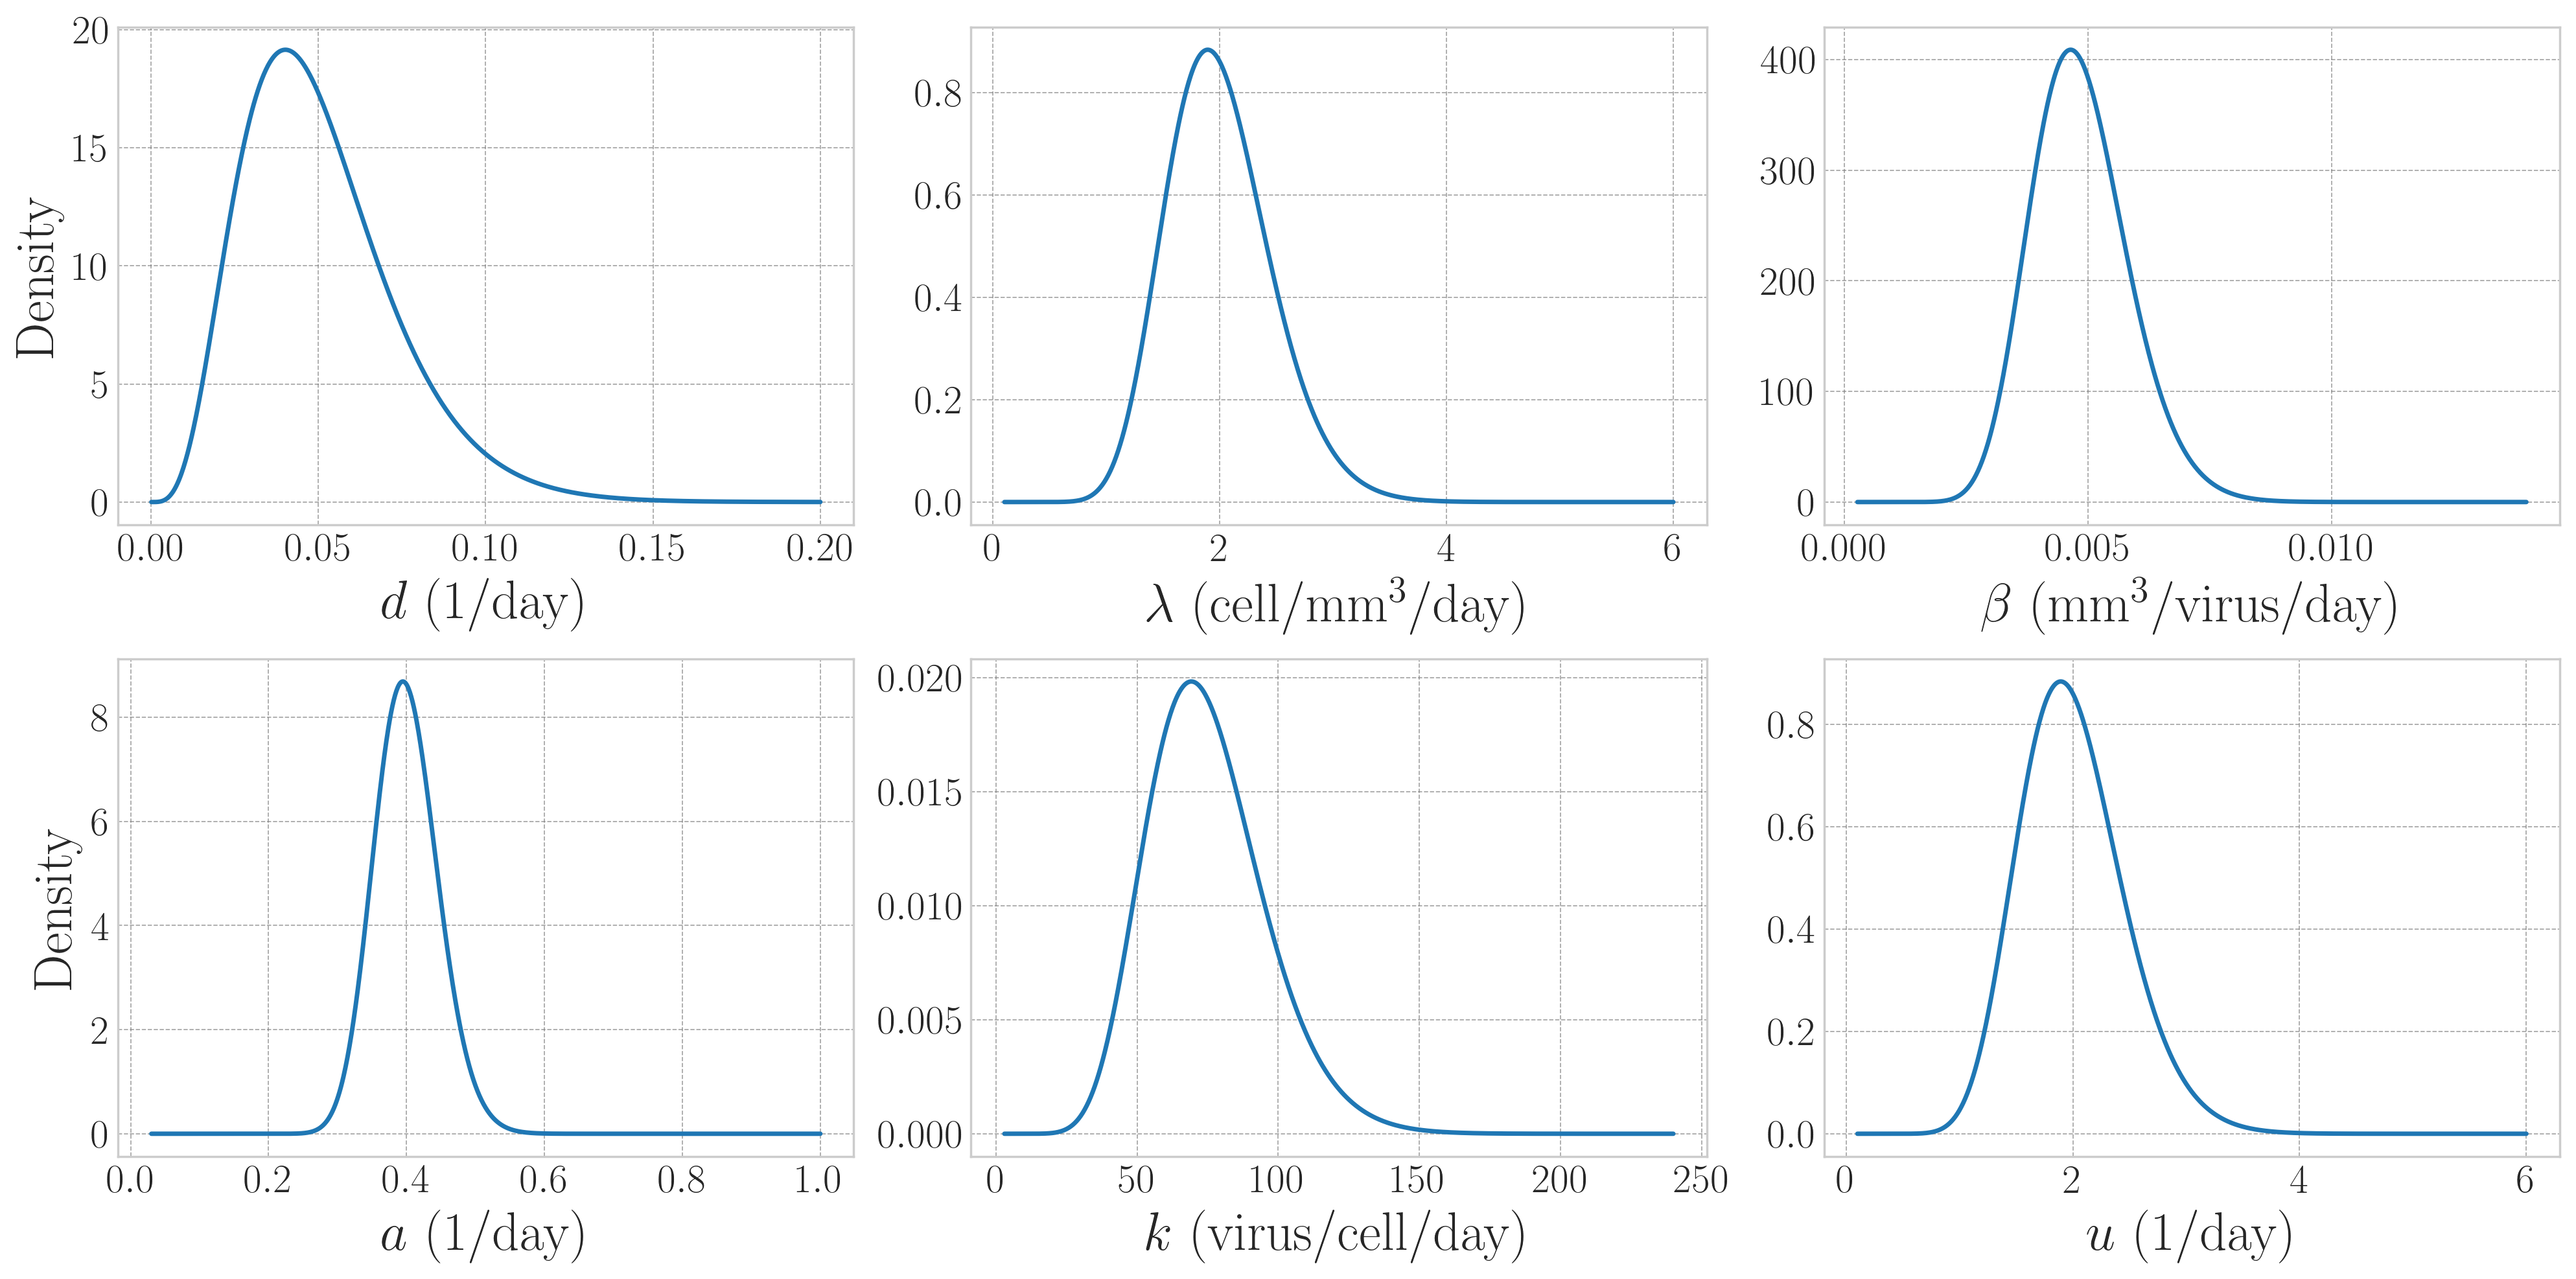

Excluded sets of parameters for population 1: 0
Excluded sets of parameters for population 2: 0


In [104]:
# == In silico clinical trial ==
"""
We compare 2 treated population (N = 100 and N = 100).
Both population are caracterized by the distribution for : d, lambda, beta, a, k, u.
We assume u = q.

The treated populations are characterized by c = 5000, alpha = 0.016, b = 2 and c = 2500, alpha = 0.004 and b = 2.
"""
N = 2500
T= 250

problem = {
    'names': [r'$d$', r'$\lambda$', r'$\beta$', r'$a$', r'$k$', r'$u$'],
    'bounds': [
        [0.001, 0.1],   # d
        [1, 3],         # lambda
        [0.0027, 0.007], # beta
        [0.3, 0.5],     # a
        [30, 120],      # k
        [1, 3]          # u
    ],
    'units': [
        '1/day',        # d
        'cell/mm$^3$/day', # lambda
        'mm$^3$/virus/day', # beta
        '1/day',        # a
        'virus/cell/day', # k
        '1/day'         # u
    ]
}

# Generate the two populations, we assume gamma distribution and we fit the parameters to the mean and std of the uniform distribution
def gamma_uniform_mean_std_matching(uniform_a, uniform_b, scaling_sigma=1):
    """
    Match a gamma distribution's parameters to a uniform distribution.

    Solves for the shape (k) and scale (theta) parameters of a gamma
    distribution that matches the mean and variance of a uniform distribution
    over the interval [a, b].

    Parameters
    ----------
    uniform_a : float
        The lower bound of the uniform distribution.
    uniform_b : float
        The upper bound of the uniform distribution.
    scaling_sigma : float, optional
        A scaling factor for the standard deviation of the uniform distribution.

    Returns
    -------
    k : float
        The shape parameter of the gamma distribution.
    theta : float
        The scale parameter of the gamma distribution.

    Notes
    -----
    The uniform distribution has:
        - Mean: (a + b) / 2
        - Variance: (b - a)^2 / 12

    The gamma distribution is parameterized as:
        p(x) = x^(k-1) * exp(-x/theta) / (theta^k * Gamma(k)),
    where the mean is k * theta and the variance is k * theta^2.

    The parameters are solved as:
        k = 3 * (a + b)^2 / (b - a)^2
        theta = (b - a)^2 / (6 * (a + b))
    """
    a = uniform_a
    b = uniform_b
    
    p = a + b
    q_sq = (b - a) ** 2
    q_sq *= scaling_sigma ** 2
    k = 3 * p ** 2 / q_sq
    theta = q_sq / (6 * p)
    return k, theta


def gamma_pdf(x, k, theta):
    return x ** (k - 1) * np.exp(-x / theta) / (theta ** k * gamma_func(k))

problem["gamma"] = []
for v in range(len(problem['names'])):
    uniform_a = problem['bounds'][v][0]
    uniform_b = problem['bounds'][v][1]
    k, theta = gamma_uniform_mean_std_matching(uniform_a, uniform_b, scaling_sigma=0.8)
    problem["gamma"].append((k, theta))

# == Figure \label{fig:population_distribution} ==
# -- Setup the figure -- #
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()

# -- Plot the results -- #
for i, (name, (k, theta), unit) in enumerate(zip(problem['names'], problem['gamma'], problem['units'])):
    uniform_a = problem['bounds'][i][0]
    uniform_b = problem['bounds'][i][1]
    x = np.linspace(uniform_a*0.1, uniform_b*2, 1000)
    y = gamma_pdf(x, k, theta)
    axs[i].plot(x, y)
    axs[i].set_xlabel(name + f" ({unit})")
    if i % 3 == 0:
        axs[i].set_ylabel('Density')

plt.tight_layout()

# save the figure in pdf format
plt.savefig('population_distribution.pdf', format='pdf', bbox_inches='tight')

plt.show()

population_1 = []
population_2 = []

for i, (k, theta) in enumerate(problem["gamma"]):
    population_1.append(np.random.gamma(k, theta, N))
    population_2.append(np.random.gamma(k, theta, N))

population_1 = np.array(population_1).T
population_2 = np.array(population_2).T
# add the parameters c, alpha and b
population_1 = np.hstack((population_1, np.ones((N, 3)) * [5000, 0.004, 2]))
population_2 = np.hstack((population_2, np.ones((N, 3)) * [2500, 0.016, 2]))

# compute R_v and R_w for each population. If R_v < 1 or R_w < 1, we remove the set of parameters.
# Print the number of excluded sets of parameters.

excluded_population_1 = 0
excluded_population_2 = 0

final_population_1 = []
final_population_2 = []

for i in range(N):
    p = {}
    p['d'] = population_1[i, 0]
    p['lambda'] = population_1[i, 1]
    p['beta'] = population_1[i, 2]
    p['a'] = population_1[i, 3]
    p['k'] = population_1[i, 4]
    p['u'] = population_1[i, 5]
    p['c'] = population_1[i, 6]
    p['alpha'] = population_1[i, 7]
    p['b'] = population_1[i, 8]
    p['q'] = p['u']

    R_v = compute_R_v(p)
    R_w = compute_R_w(p)

    if R_v >= 1 and R_w >= 1:
        final_population_1.append(population_1[i])
    else:
        excluded_population_1 += 1

for i in range(N):
    p = {}
    p['d'] = population_2[i, 0]
    p['lambda'] = population_2[i, 1]
    p['beta'] = population_2[i, 2]
    p['a'] = population_2[i, 3]
    p['k'] = population_2[i, 4]
    p['u'] = population_2[i, 5]
    p['c'] = population_2[i, 6]
    p['alpha'] = population_2[i, 7]
    p['b'] = population_2[i, 8]
    p['q'] = p['u']

    R_v = compute_R_v(p)
    R_w = compute_R_w(p)

    if R_v >= 1 and R_w >= 1:
        final_population_2.append(population_2[i])
    else:
        excluded_population_2 += 1

final_population_1 = np.array(final_population_1)
final_population_2 = np.array(final_population_2)
population_1 = final_population_1
population_2 = final_population_2

print(f"Excluded sets of parameters for population 1: {excluded_population_1}")
print(f"Excluded sets of parameters for population 2: {excluded_population_2}")

In [105]:

# -- Run the simulations -- #
results_population_1 = []
results_population_2 = []
import concurrent.futures

def run_simulation(params, u0):
    solution_single_infection = solve_ivp(
        fun=lambda t, y: double_infection_system(t, y, params),
        t_span=(0, T),
        y0=u0,
        t_eval=np.arange(0, T, dt),
        method='BDF',
        rtol=1e-6,
        max_step=dt
    )
    return [solution_single_infection.y[0], solution_single_infection.y[3]]

def prepare_params_and_u0(population):
    params_list = []
    u0_list = []
    for i in range(N):
        params = {}
        params['d'] = population[i, 0]
        params['lambda'] = population[i, 1]
        params['beta'] = population[i, 2]
        params['a'] = population[i, 3]
        params['k'] = population[i, 4]
        params['u'] = population[i, 5]
        params['c'] = population[i, 6]
        params['alpha'] = population[i, 7]
        params['b'] = population[i, 8]
        params['q'] = params['u']

        u0_s = single_infection_equilibrium(params)
        u0 = np.zeros(5)
        u0[0] = u0_s[0]
        u0[1] = u0_s[1]
        u0[2] = 0
        u0[3] = u0_s[3]
        u0[4] = 1 # inject a few recombinant viruses

        params_list.append(params)
        u0_list.append(u0)
    return params_list, u0_list

params_list_1, u0_list_1 = prepare_params_and_u0(population_1)
params_list_2, u0_list_2 = prepare_params_and_u0(population_2)

with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    results_population_1 = list(tqdm(executor.map(run_simulation, params_list_1, u0_list_1), total=N))
    results_population_2 = list(tqdm(executor.map(run_simulation, params_list_2, u0_list_2), total=N))

results_population_1 = np.array(results_population_1)
results_population_2 = np.array(results_population_2)

100%|██████████| 2500/2500 [01:18<00:00, 31.79it/s]


Number of stable solutions for population 1: 2046
Number of oscillatory solutions for population 1: 454
Number of stable solutions for population 2: 2371
Number of oscillatory solutions for population 2: 129


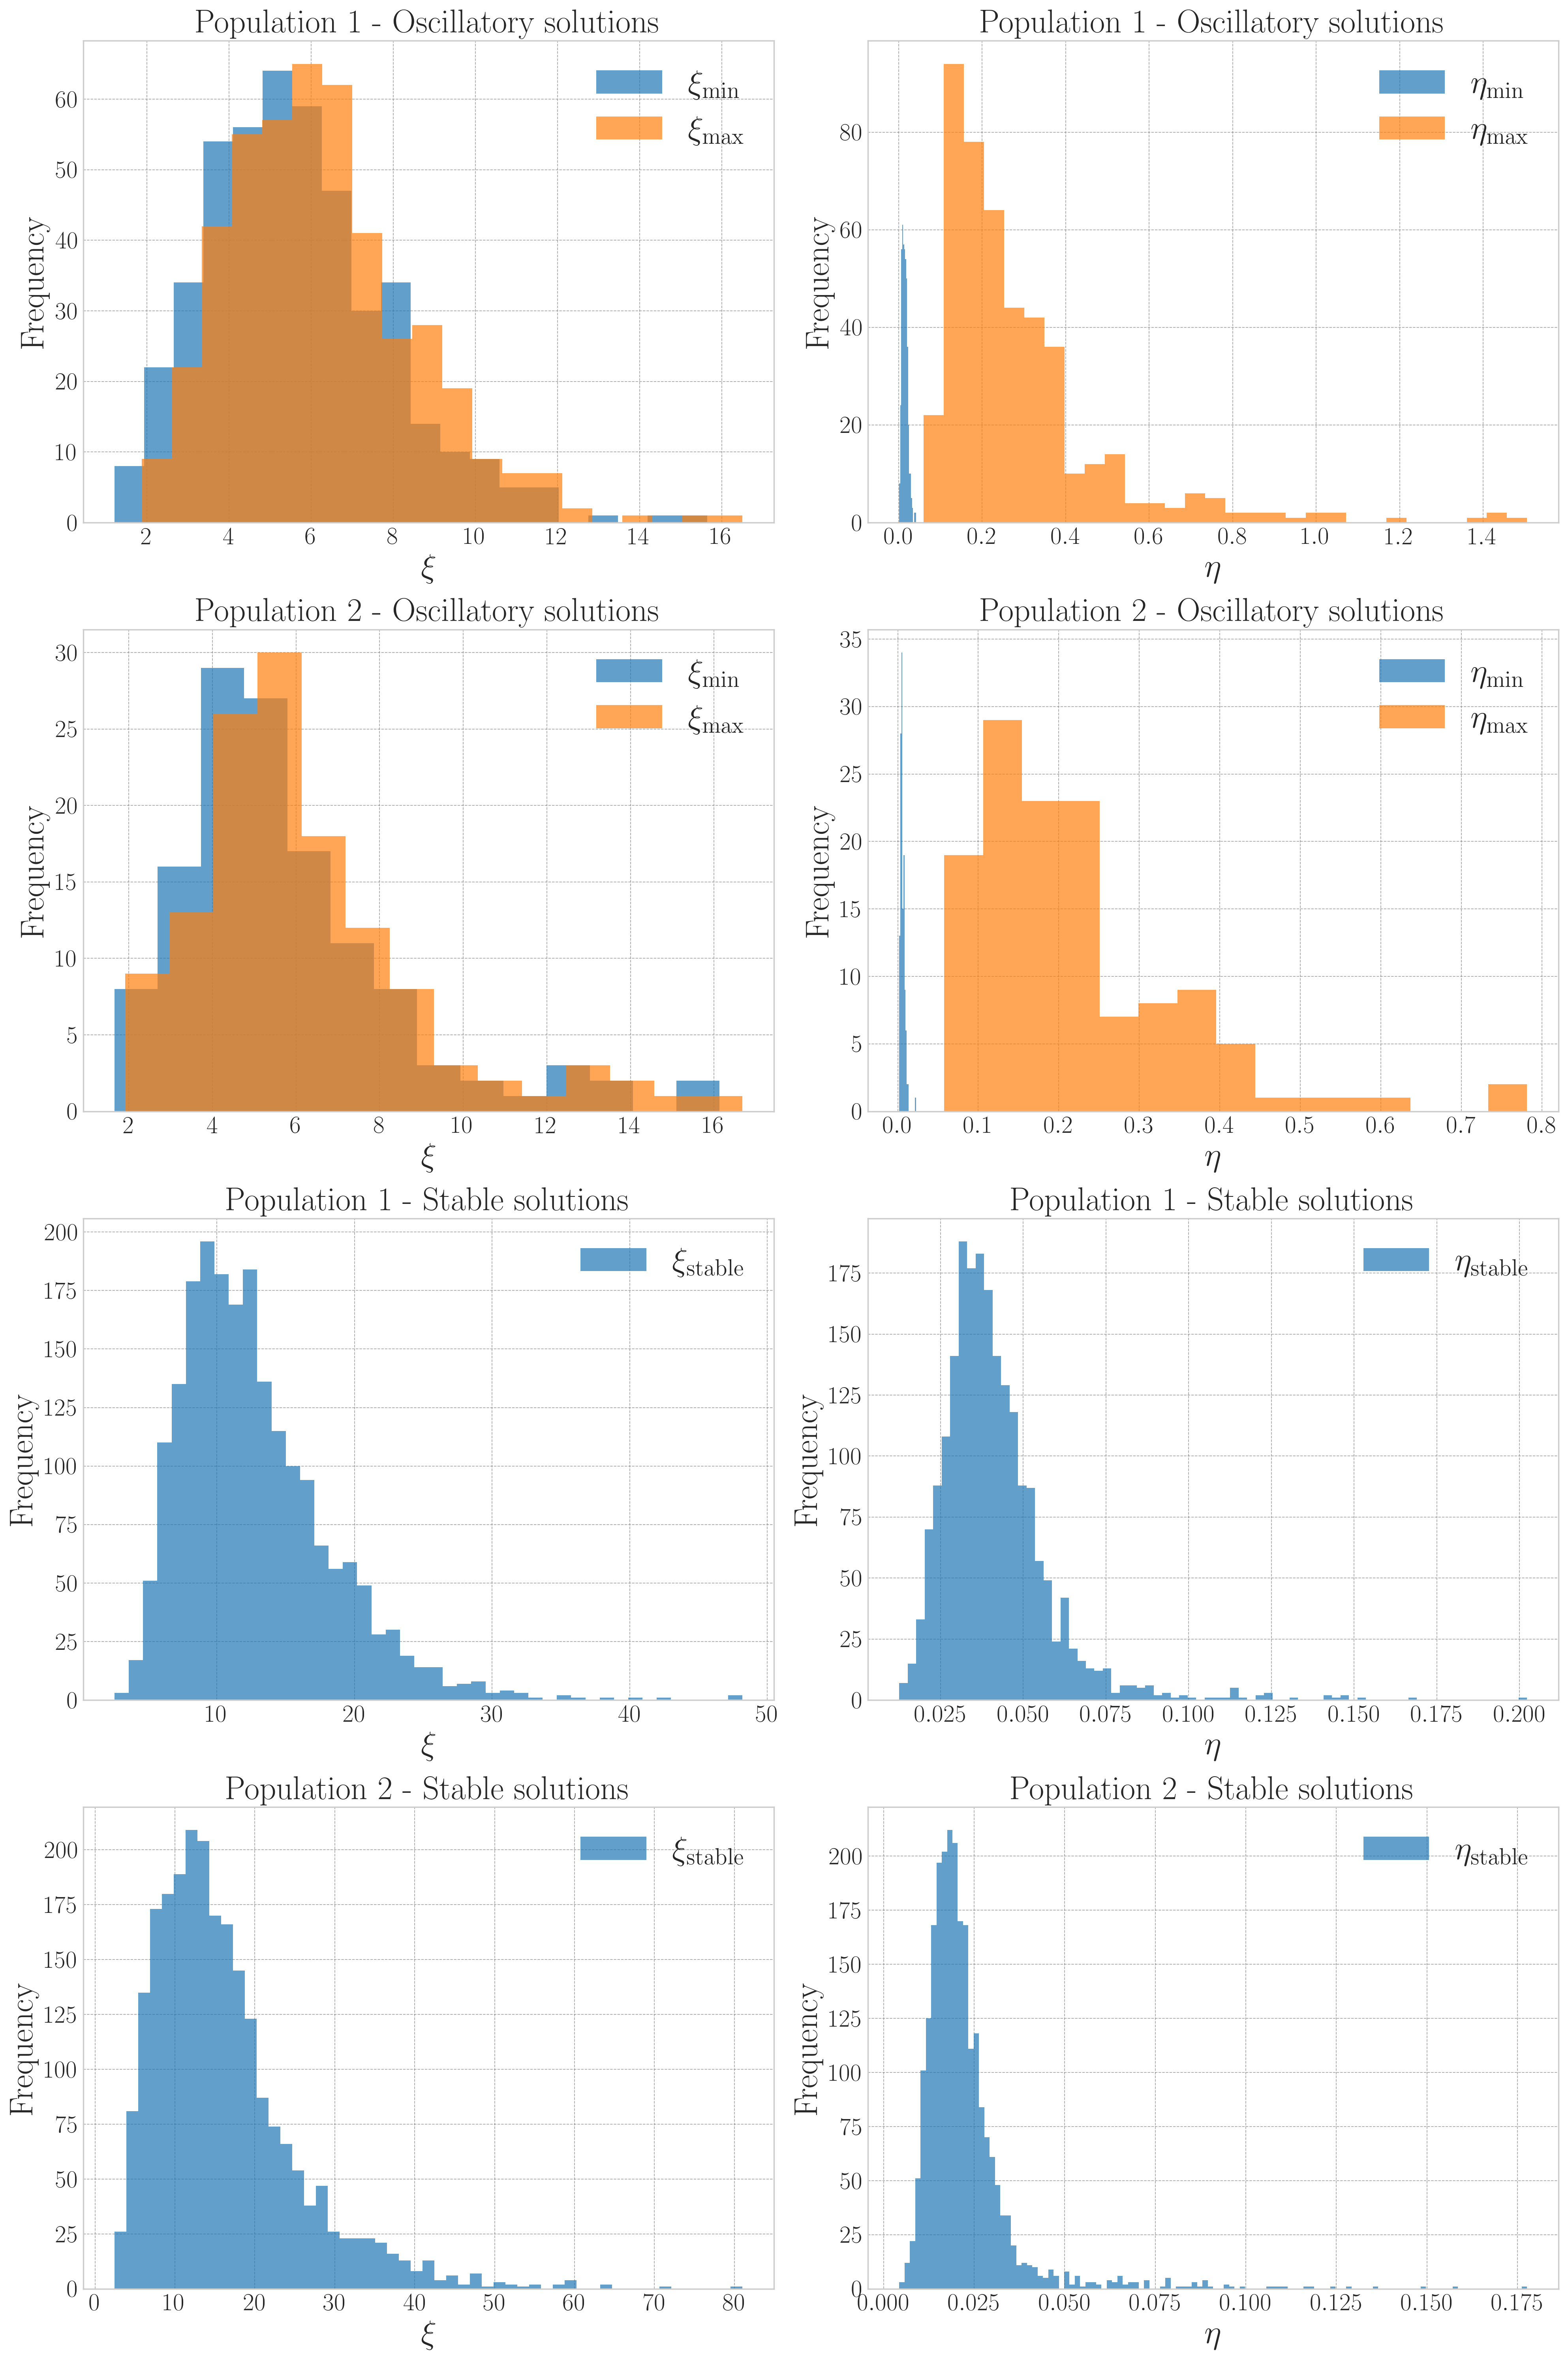

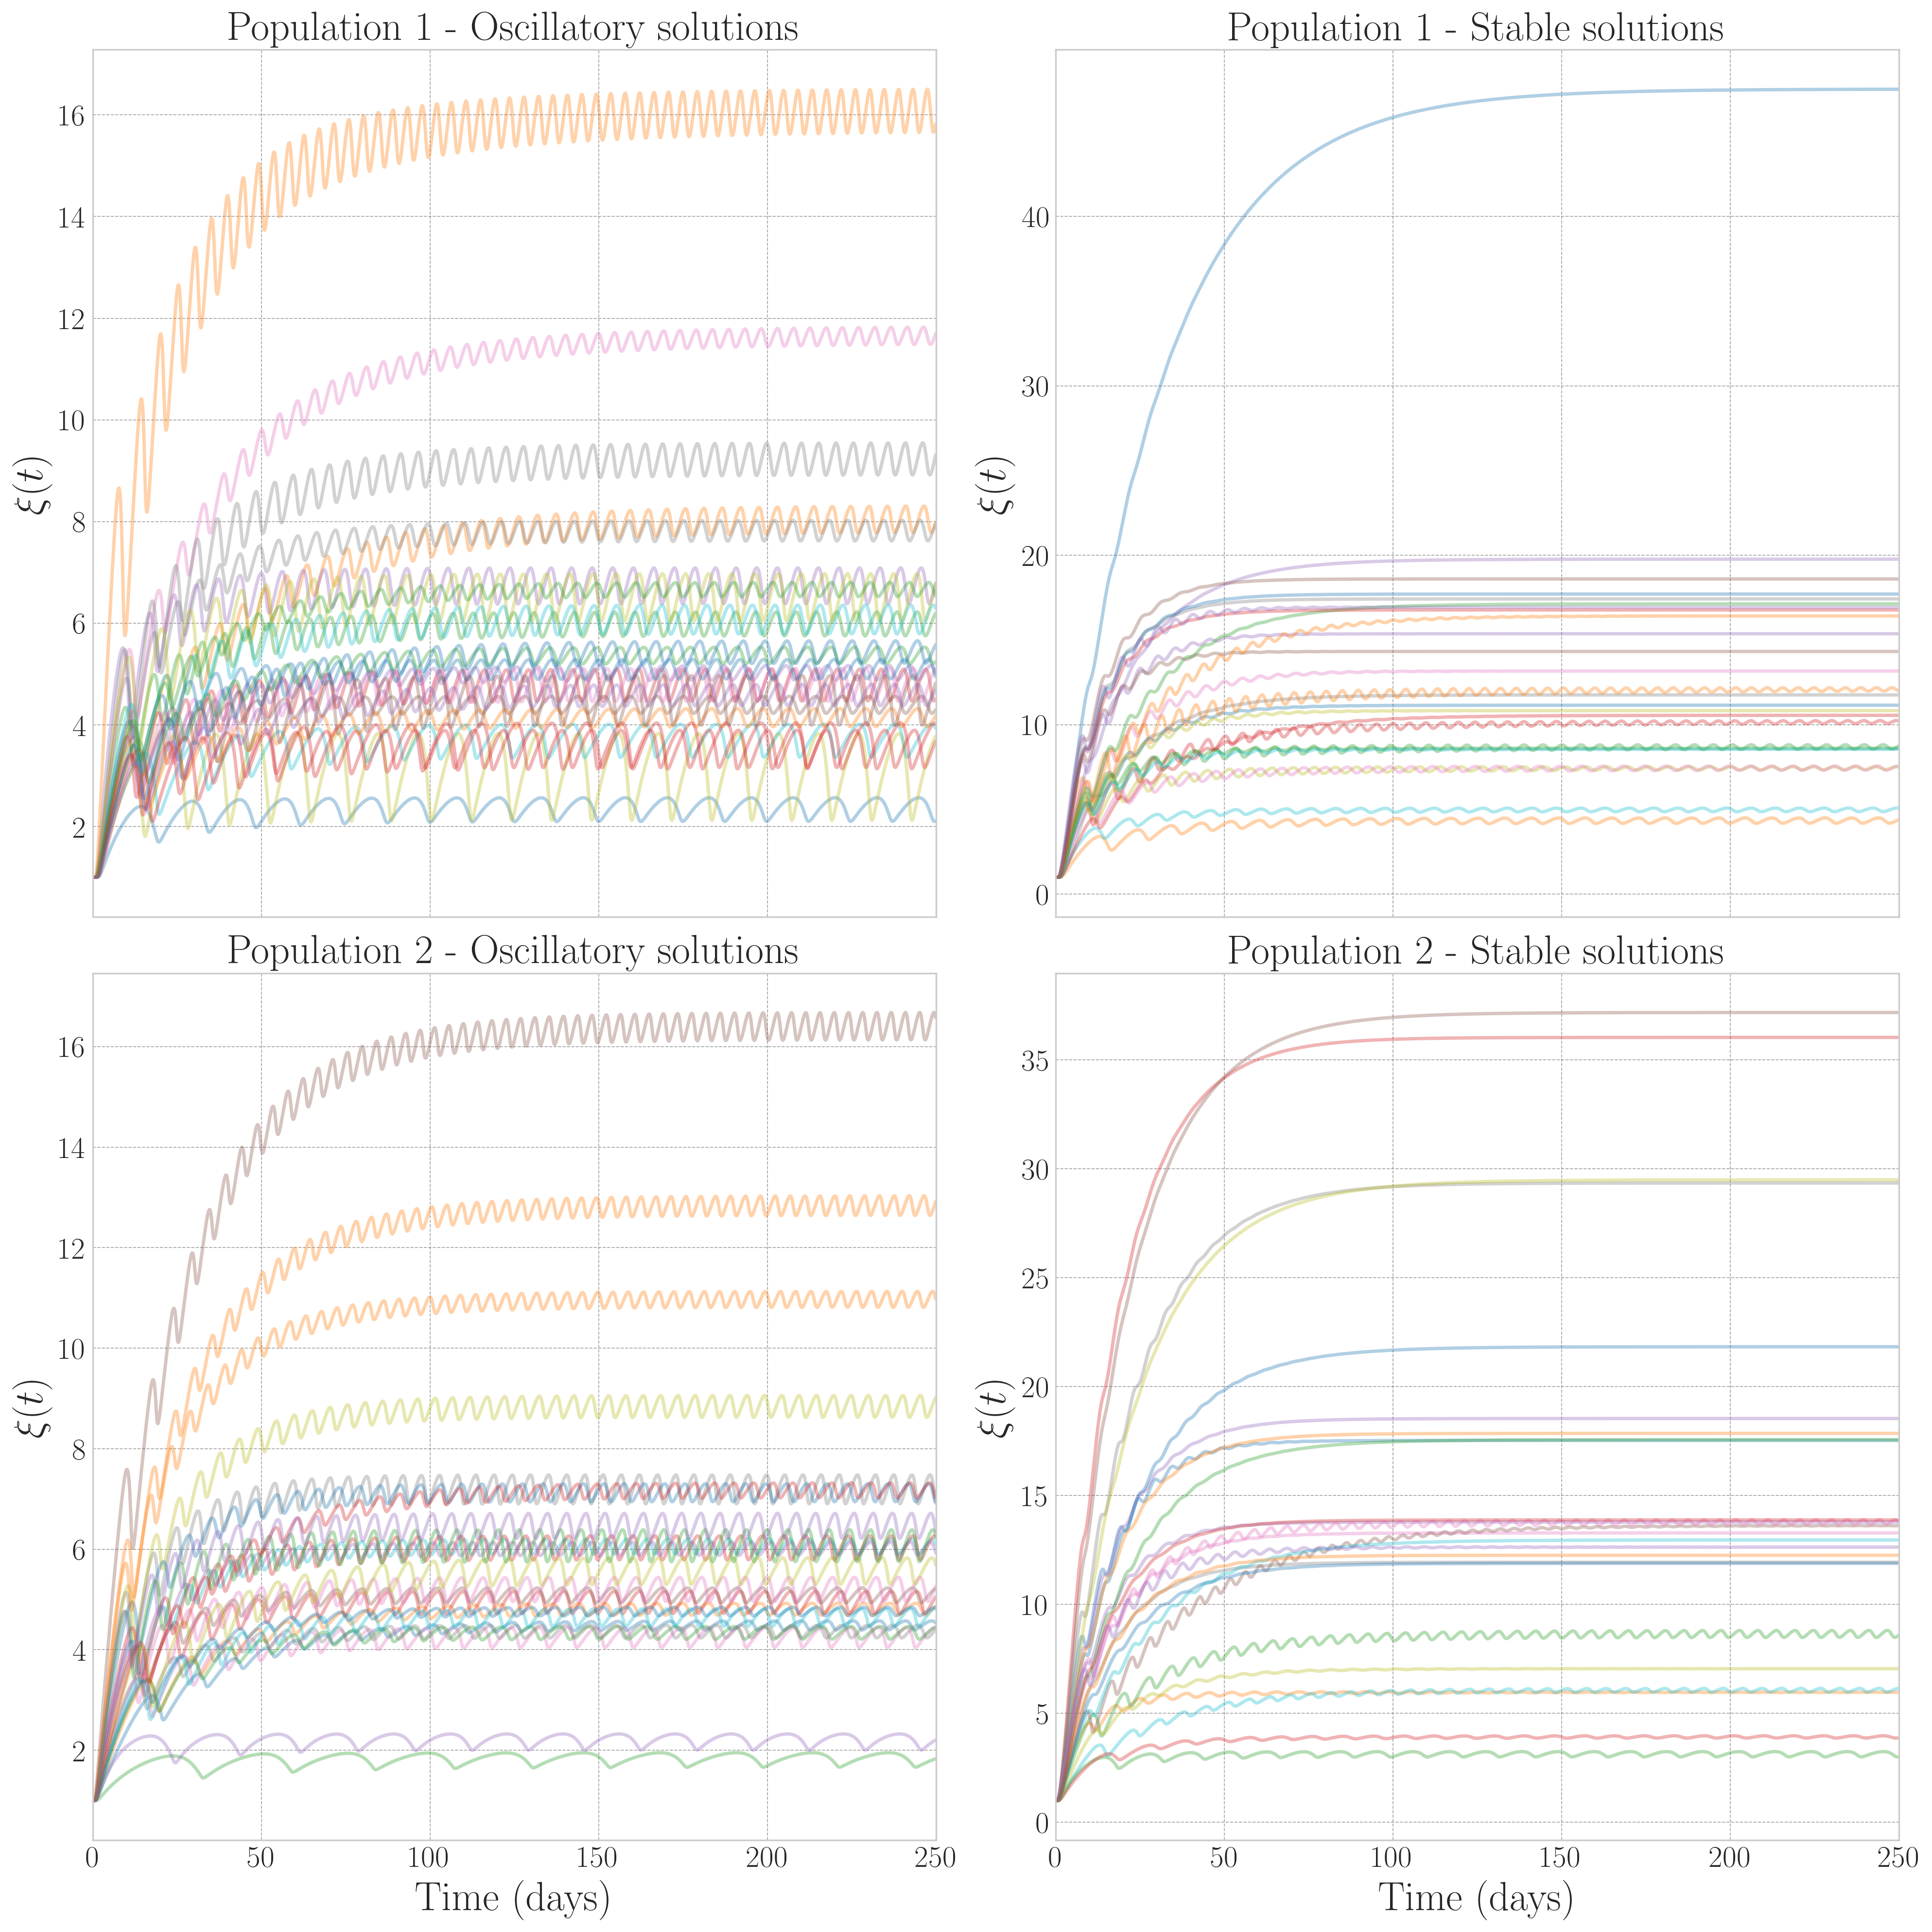

Population 1 - Oscillatory solutions:
xi_min_mean: 5.65854251299474
xi_min_std: 2.2303600667190375
xi_min_min: 1.2138778983445149
xi_min_median: 5.39756767917852
xi_max_mean: 6.254825106918035
xi_max_std: 2.2519738972618395
xi_max_max: 16.50471496864067
xi_max_median: 5.949744749251763
eta_min_mean: 0.014805386406775992
eta_min_std: 0.006758314902036474
eta_min_min: 0.001528735391386763
eta_min_median: 0.014189672982720909
eta_max_mean: 0.28899218124501663
eta_max_std: 0.20955639119347924
eta_max_max: 1.5051670461918527
eta_max_median: 0.22699847412160395

Population 2 - Oscillatory solutions:
xi_min_mean: 5.7998825220815124
xi_min_std: 2.6954388371364937
xi_min_min: 1.6598133378348714
xi_min_median: 5.301779633560543
xi_max_mean: 6.170005877750466
xi_max_std: 2.720992919138253
xi_max_max: 16.67821161574556
xi_max_median: 5.641009765752686
eta_min_mean: 0.005924914329082268
eta_min_std: 0.002791058579837908
eta_min_min: 0.0018344558697041518
eta_min_median: 0.005256860340828691
eta_max

In [106]:
# -- Work on the results -- #
# Separation between stable and oscillatory solutions : between day 225 and day 200, look at x = y[0] and if max - min < 1 : stable, otherwise oscillatory

stable_population_1 = []
oscillatory_population_1 = []

for i in range(N):
    x = results_population_1[i, 0]
    if np.max(x[int(225/dt):]) - np.min(x[int(225/dt):]) < 1:
        stable_population_1.append(results_population_1[i])
    else:
        oscillatory_population_1.append(results_population_1[i])

stable_population_1 = np.array(stable_population_1)
oscillatory_population_1 = np.array(oscillatory_population_1)

stable_population_2 = []
oscillatory_population_2 = []

parameters_population_2_stable = []
parameters_population_2_oscillatory = []

for i in range(N):
    x = results_population_2[i, 0]
    if np.max(x[int(225/dt):]) - np.min(x[int(225/dt):]) < 1:
        stable_population_2.append(results_population_2[i])
        parameters_population_2_stable.append(population_2[i])
    else:
        oscillatory_population_2.append(results_population_2[i])
        parameters_population_2_oscillatory.append(population_2[i])

stable_population_2 = np.array(stable_population_2)
oscillatory_population_2 = np.array(oscillatory_population_2)

parameters_population_2_stable = np.array(parameters_population_2_stable)
parameters_population_2_oscillatory = np.array(parameters_population_2_oscillatory)

print(f"Number of stable solutions for population 1: {stable_population_1.shape[0]}")
print(f"Number of oscillatory solutions for population 1: {oscillatory_population_1.shape[0]}")
print(f"Number of stable solutions for population 2: {stable_population_2.shape[0]}")
print(f"Number of oscillatory solutions for population 2: {oscillatory_population_2.shape[0]}")

# compute xi_min and xi_max for oscillatory solutions and eta_min and eta_max for oscillatory solutions
xi_min_oscillatory_population_1 = []
xi_max_oscillatory_population_1 = []
eta_min_oscillatory_population_1 = []
eta_max_oscillatory_population_1 = []

for i in range(oscillatory_population_1.shape[0]):
    xi_min_oscillatory_population_1.append(np.min(oscillatory_population_1[i, 0][int(225/dt):]) / oscillatory_population_1[i, 0][0])
    xi_max_oscillatory_population_1.append(np.max(oscillatory_population_1[i, 0][int(225/dt):]) / oscillatory_population_1[i, 0][0])
    eta_min_oscillatory_population_1.append(np.min(oscillatory_population_1[i, 1][int(225/dt):]) / oscillatory_population_1[i, 1][0])
    eta_max_oscillatory_population_1.append(np.max(oscillatory_population_1[i, 1][int(225/dt):]) / oscillatory_population_1[i, 1][0])

xi_min_oscillatory_population_2 = []
xi_max_oscillatory_population_2 = []
eta_min_oscillatory_population_2 = []
eta_max_oscillatory_population_2 = []

for i in range(oscillatory_population_2.shape[0]):
    #xi = x_3 / x_2^*
    #eta = v_3 / v_2^*
    # x_2^* = oscillatory_population_2[i, 0][0]
    # v_2^* = oscillatory_population_2[i, 1][0]

    xi_min_oscillatory_population_2.append(np.min(oscillatory_population_2[i, 0][int(225/dt):]) / oscillatory_population_2[i, 0][0])
    xi_max_oscillatory_population_2.append(np.max(oscillatory_population_2[i, 0][int(225/dt):]) / oscillatory_population_2[i, 0][0])
    eta_min_oscillatory_population_2.append(np.min(oscillatory_population_2[i, 1][int(225/dt):]) / oscillatory_population_2[i, 1][0])
    eta_max_oscillatory_population_2.append(np.max(oscillatory_population_2[i, 1][int(225/dt):]) / oscillatory_population_2[i, 1][0])

# compute xi and eta for stable solutions
xi_stable_population_1 = []
eta_stable_population_1 = []

for i in range(stable_population_1.shape[0]):
    xi_stable_population_1.append(stable_population_1[i, 0][-1] / stable_population_1[i, 0][0])
    eta_stable_population_1.append(stable_population_1[i, 1][-1] / stable_population_1[i, 1][0])

xi_stable_population_2 = []
eta_stable_population_2 = []

for i in range(stable_population_2.shape[0]):
    xi_stable_population_2.append(stable_population_2[i, 0][-1] / stable_population_2[i, 0][0])
    eta_stable_population_2.append(stable_population_2[i, 1][-1] / stable_population_2[i, 1][0])

# -- Plot the results as box plots -- #
fig, axs = plt.subplots(4, 2, figsize=(16, 12))
axs = axs.flatten()

axs[0].boxplot([xi_min_oscillatory_population_1, xi_max_oscillatory_population_1], tick_labels=[r'$\xi_{\min}$', r'$\xi_{\max}$'], showmeans=True)
axs[0].set_title("Population 1 - Oscillatory solutions")
axs[0].set_ylabel(r'$\xi$')
axs[0].set_ylim((0,16))

axs[2].boxplot([eta_min_oscillatory_population_1, eta_max_oscillatory_population_1], tick_labels=[r'$\eta_{\min}$', r'$\eta_{\max}$'], showmeans=True)
axs[2].set_title("Population 1 - Oscillatory solutions")
axs[2].set_ylabel(r'$\eta$')
axs[2].set_ylim((0,1.6))

axs[1].boxplot([xi_min_oscillatory_population_2, xi_max_oscillatory_population_2], tick_labels=[r'$\xi_{\min}$', r'$\xi_{\max}$'], showmeans=True)
axs[1].set_title("Population 2 - Oscillatory solutions")
axs[1].set_ylabel(r'$\xi$')
axs[1].set_ylim((0,16))

axs[3].boxplot([eta_min_oscillatory_population_2, eta_max_oscillatory_population_2], tick_labels=[r'$\eta_{\min}$', r'$\eta_{\max}$'], showmeans=True)
axs[3].set_title("Population 2 - Oscillatory solutions")
axs[3].set_ylabel(r'$\eta$')
axs[3].set_ylim((0,1.6))

axs[4].boxplot(xi_stable_population_1, tick_labels=[r'$\xi_{\text{stable}}$'], showmeans=True)
axs[4].set_title("Population 1 - Stable solutions")
axs[4].set_ylabel(r'$\xi$')
axs[4].set_ylim((0,75))

axs[5].boxplot(xi_stable_population_2, tick_labels=[r'$\xi_{\text{stable}}$'], showmeans=True)
axs[5].set_title("Population 2 - Stable solutions")
axs[5].set_ylabel(r'$\xi$')
axs[5].set_ylim((0,75))

axs[6].boxplot(eta_stable_population_1, tick_labels=[r'$\eta_{\text{stable}}$'], showmeans=True)
axs[6].set_title("Population 1 - Stable solutions")
axs[6].set_ylabel(r'$\eta$')
axs[6].set_ylim((0,0.22))

axs[7].boxplot(eta_stable_population_2, tick_labels=[r'$\eta_{\text{stable}}$'], showmeans=True)
axs[7].set_title("Population 2 - Stable solutions")
axs[7].set_ylabel(r'$\eta$')
axs[7].set_ylim((0,0.22))

for ax in axs:
    ax.set_ylim(bottom=0)

plt.tight_layout()

# save the figure in pdf format
plt.savefig('box_plots_trials.pdf', format='pdf', bbox_inches='tight')

plt.show()

# make histograms of the results
fig, axs = plt.subplots(4, 2, figsize=(16, 24))
axs = axs.flatten()

# Oscillatory solutions for Population 1
axs[0].hist(xi_min_oscillatory_population_1, bins='auto', alpha=0.7, label=r'$\xi_{\min}$')
axs[0].hist(xi_max_oscillatory_population_1, bins='auto', alpha=0.7, label=r'$\xi_{\max}$')
axs[0].set_title("Population 1 - Oscillatory solutions")
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel(r'$\xi$')
axs[0].legend()

axs[1].hist(eta_min_oscillatory_population_1, bins='auto', alpha=0.7, label=r'$\eta_{\min}$')
axs[1].hist(eta_max_oscillatory_population_1, bins='auto', alpha=0.7, label=r'$\eta_{\max}$')
axs[1].set_title("Population 1 - Oscillatory solutions")
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel(r'$\eta$')
axs[1].legend()

# Oscillatory solutions for Population 2
axs[2].hist(xi_min_oscillatory_population_2, bins='auto', alpha=0.7, label=r'$\xi_{\min}$')
axs[2].hist(xi_max_oscillatory_population_2, bins='auto', alpha=0.7, label=r'$\xi_{\max}$')
axs[2].set_title("Population 2 - Oscillatory solutions")
axs[2].set_ylabel("Frequency")
axs[2].set_xlabel(r'$\xi$')
axs[2].legend()

axs[3].hist(eta_min_oscillatory_population_2, bins='auto', alpha=0.7, label=r'$\eta_{\min}$')
axs[3].hist(eta_max_oscillatory_population_2, bins='auto', alpha=0.7, label=r'$\eta_{\max}$')
axs[3].set_title("Population 2 - Oscillatory solutions")
axs[3].set_ylabel("Frequency")
axs[3].set_xlabel(r'$\eta$')
axs[3].legend()

# Stable solutions for Population 1
axs[4].hist(xi_stable_population_1, bins='auto', alpha=0.7, label=r'$\xi_{\text{stable}}$')
axs[4].set_title("Population 1 - Stable solutions")
axs[4].set_ylabel("Frequency")
axs[4].set_xlabel(r'$\xi$')
axs[4].legend()

axs[5].hist(eta_stable_population_1, bins='auto', alpha=0.7, label=r'$\eta_{\text{stable}}$')
axs[5].set_title("Population 1 - Stable solutions")
axs[5].set_ylabel("Frequency")
axs[5].set_xlabel(r'$\eta$')
axs[5].legend()

# Stable solutions for Population 2
axs[6].hist(xi_stable_population_2, bins='auto', alpha=0.7, label=r'$\xi_{\text{stable}}$')
axs[6].set_title("Population 2 - Stable solutions")
axs[6].set_ylabel("Frequency")
axs[6].set_xlabel(r'$\xi$')
axs[6].legend()

axs[7].hist(eta_stable_population_2, bins='auto', alpha=0.7, label=r'$\eta_{\text{stable}}$')
axs[7].set_title("Population 2 - Stable solutions")
axs[7].set_ylabel("Frequency")
axs[7].set_xlabel(r'$\eta$')
axs[7].legend()

plt.tight_layout()

# save the figure in pdf format
plt.savefig('histograms_trials.pdf', format='pdf', bbox_inches='tight')

plt.show()

# plots of the traces for a few oscillatory solutions and a few stable solutions (four plots)
fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharex=True)
axs = axs.flatten()

# Plot a few oscillatory solutions for population 1
for i in range(min(25, oscillatory_population_1.shape[0])):
    axs[0].plot(np.arange(len(oscillatory_population_1[i, 0])) * dt, oscillatory_population_1[i, 0] / oscillatory_population_1[i, 0][0], alpha=0.35)
axs[0].set_title("Population 1 - Oscillatory solutions")
axs[0].set_ylabel(r'$\xi(t)$')
axs[0].set_xlim(0, T)

# Plot a few stable solutions for population 1
for i in range(min(25, stable_population_1.shape[0])):
    axs[1].plot(np.arange(len(stable_population_1[i, 0])) * dt, stable_population_1[i, 0] / stable_population_1[i, 0][0], alpha=0.35)
axs[1].set_title("Population 1 - Stable solutions")
axs[1].set_ylabel(r'$\xi(t)$')
axs[1].set_xlim(0, T)

# Plot a few oscillatory solutions for population 2
for i in range(min(25, oscillatory_population_2.shape[0])):
    axs[2].plot(np.arange(len(oscillatory_population_2[i, 0])) * dt, oscillatory_population_2[i, 0] / oscillatory_population_2[i, 0][0], alpha=0.35)
axs[2].set_title("Population 2 - Oscillatory solutions")
axs[2].set_xlabel("Time (days)")
axs[2].set_ylabel(r'$\xi(t)$')
axs[2].set_xlim(0, T)

# Plot a few stable solutions for population 2
for i in range(min(25, stable_population_2.shape[0])):
    axs[3].plot(np.arange(len(stable_population_2[i, 0])) * dt, stable_population_2[i, 0] / stable_population_2[i, 0][0], alpha=0.35)
axs[3].set_title("Population 2 - Stable solutions")
axs[3].set_xlabel("Time (days)")
axs[3].set_ylabel(r'$\xi(t)$')
axs[3].set_xlim(0, T)

plt.tight_layout()

# save the figure in pdf format
plt.savefig('traces_trials.pdf', format='pdf', bbox_inches='tight')

plt.show()

"""% xi_min_mean :
% xi_min_std :
% xi_min_min :
% xi_min_median :
% pareil pour xi_max;
% pareil pour eta_min;
% pareil pour eta_max;
% xi_min :
% xi_max :
% xi_meadian:
% xi_ mean:
% xi_std:
% pareil pour eta;
"""
# -- Compute the statistics -- #
xi_min_mean_oscillatory_population_1 = np.mean(xi_min_oscillatory_population_1)
xi_min_std_oscillatory_population_1 = np.std(xi_min_oscillatory_population_1)
xi_min_min_oscillatory_population_1 = np.min(xi_min_oscillatory_population_1)
xi_min_median_oscillatory_population_1 = np.median(xi_min_oscillatory_population_1)

xi_max_mean_oscillatory_population_1 = np.mean(xi_max_oscillatory_population_1)
xi_max_std_oscillatory_population_1 = np.std(xi_max_oscillatory_population_1)
xi_max_max_oscillatory_population_1 = np.max(xi_max_oscillatory_population_1)
xi_max_median_oscillatory_population_1 = np.median(xi_max_oscillatory_population_1)

eta_min_mean_oscillatory_population_1 = np.mean(eta_min_oscillatory_population_1)
eta_min_std_oscillatory_population_1 = np.std(eta_min_oscillatory_population_1)
eta_min_min_oscillatory_population_1 = np.min(eta_min_oscillatory_population_1)
eta_min_median_oscillatory_population_1 = np.median(eta_min_oscillatory_population_1)

eta_max_mean_oscillatory_population_1 = np.mean(eta_max_oscillatory_population_1)
eta_max_std_oscillatory_population_1 = np.std(eta_max_oscillatory_population_1)
eta_max_max_oscillatory_population_1 = np.max(eta_max_oscillatory_population_1)
eta_max_median_oscillatory_population_1 = np.median(eta_max_oscillatory_population_1)

xi_min_mean_oscillatory_population_2 = np.mean(xi_min_oscillatory_population_2)
xi_min_std_oscillatory_population_2 = np.std(xi_min_oscillatory_population_2)
xi_min_min_oscillatory_population_2 = np.min(xi_min_oscillatory_population_2)
xi_min_median_oscillatory_population_2 = np.median(xi_min_oscillatory_population_2)

xi_max_mean_oscillatory_population_2 = np.mean(xi_max_oscillatory_population_2)
xi_max_std_oscillatory_population_2 = np.std(xi_max_oscillatory_population_2)
xi_max_max_oscillatory_population_2 = np.max(xi_max_oscillatory_population_2)
xi_max_median_oscillatory_population_2 = np.median(xi_max_oscillatory_population_2)

eta_min_mean_oscillatory_population_2 = np.mean(eta_min_oscillatory_population_2)
eta_min_std_oscillatory_population_2 = np.std(eta_min_oscillatory_population_2)
eta_min_min_oscillatory_population_2 = np.min(eta_min_oscillatory_population_2)
eta_min_median_oscillatory_population_2 = np.median(eta_min_oscillatory_population_2)

eta_max_mean_oscillatory_population_2 = np.mean(eta_max_oscillatory_population_2)
eta_max_std_oscillatory_population_2 = np.std(eta_max_oscillatory_population_2)
eta_max_max_oscillatory_population_2 = np.max(eta_max_oscillatory_population_2)
eta_max_median_oscillatory_population_2 = np.median(eta_max_oscillatory_population_2)

xi_mean_stable_population_1 = np.mean(xi_stable_population_1)
xi_std_stable_population_1 = np.std(xi_stable_population_1)
xi_min_stable_population_1 = np.min(xi_stable_population_1)
xi_median_stable_population_1 = np.median(xi_stable_population_1)
xi_max_stable_population_1 = np.max(xi_stable_population_1)

eta_mean_stable_population_1 = np.mean(eta_stable_population_1)
eta_std_stable_population_1 = np.std(eta_stable_population_1)
eta_min_stable_population_1 = np.min(eta_stable_population_1)
eta_median_stable_population_1 = np.median(eta_stable_population_1)
eta_max_stable_population_1 = np.max(eta_stable_population_1)

xi_mean_stable_population_2 = np.mean(xi_stable_population_2)
xi_std_stable_population_2 = np.std(xi_stable_population_2)
xi_min_stable_population_2 = np.min(xi_stable_population_2)
xi_median_stable_population_2 = np.median(xi_stable_population_2)
xi_max_stable_population_2 = np.max(xi_stable_population_2)

eta_mean_stable_population_2 = np.mean(eta_stable_population_2)
eta_std_stable_population_2 = np.std(eta_stable_population_2)
eta_min_stable_population_2 = np.min(eta_stable_population_2)
eta_median_stable_population_2 = np.median(eta_stable_population_2)
eta_max_stable_population_2 = np.max(eta_stable_population_2)

# Print the statistics
print(f"Population 1 - Oscillatory solutions:")
print(f"xi_min_mean: {xi_min_mean_oscillatory_population_1}")
print(f"xi_min_std: {xi_min_std_oscillatory_population_1}")
print(f"xi_min_min: {xi_min_min_oscillatory_population_1}")
print(f"xi_min_median: {xi_min_median_oscillatory_population_1}")
print(f"xi_max_mean: {xi_max_mean_oscillatory_population_1}")
print(f"xi_max_std: {xi_max_std_oscillatory_population_1}")
print(f"xi_max_max: {xi_max_max_oscillatory_population_1}")
print(f"xi_max_median: {xi_max_median_oscillatory_population_1}")
print(f"eta_min_mean: {eta_min_mean_oscillatory_population_1}")
print(f"eta_min_std: {eta_min_std_oscillatory_population_1}")
print(f"eta_min_min: {eta_min_min_oscillatory_population_1}")
print(f"eta_min_median: {eta_min_median_oscillatory_population_1}")
print(f"eta_max_mean: {eta_max_mean_oscillatory_population_1}")
print(f"eta_max_std: {eta_max_std_oscillatory_population_1}")
print(f"eta_max_max: {eta_max_max_oscillatory_population_1}")
print(f"eta_max_median: {eta_max_median_oscillatory_population_1}")

print(f"\nPopulation 2 - Oscillatory solutions:")
print(f"xi_min_mean: {xi_min_mean_oscillatory_population_2}")
print(f"xi_min_std: {xi_min_std_oscillatory_population_2}")
print(f"xi_min_min: {xi_min_min_oscillatory_population_2}")
print(f"xi_min_median: {xi_min_median_oscillatory_population_2}")
print(f"xi_max_mean: {xi_max_mean_oscillatory_population_2}")
print(f"xi_max_std: {xi_max_std_oscillatory_population_2}")
print(f"xi_max_max: {xi_max_max_oscillatory_population_2}")
print(f"xi_max_median: {xi_max_median_oscillatory_population_2}")
print(f"eta_min_mean: {eta_min_mean_oscillatory_population_2}")
print(f"eta_min_std: {eta_min_std_oscillatory_population_2}")
print(f"eta_min_min: {eta_min_min_oscillatory_population_2}")
print(f"eta_min_median: {eta_min_median_oscillatory_population_2}")
print(f"eta_max_mean: {eta_max_mean_oscillatory_population_2}")
print(f"eta_max_std: {eta_max_std_oscillatory_population_2}")
print(f"eta_max_max: {eta_max_max_oscillatory_population_2}")
print(f"eta_max_median: {eta_max_median_oscillatory_population_2}")

print(f"\nPopulation 1 - Stable solutions:")
print(f"xi_mean: {xi_mean_stable_population_1}")
print(f"xi_std: {xi_std_stable_population_1}")
print(f"xi_min: {xi_min_stable_population_1}")
print(f"xi_median: {xi_median_stable_population_1}")
print(f"xi_max: {xi_max_stable_population_1}")
print(f"eta_mean: {eta_mean_stable_population_1}")
print(f"eta_std: {eta_std_stable_population_1}")
print(f"eta_min: {eta_min_stable_population_1}")
print(f"eta_median: {eta_median_stable_population_1}")
print(f"eta_max: {eta_max_stable_population_1}")

print(f"\nPopulation 2 - Stable solutions:")
print(f"xi_mean: {xi_mean_stable_population_2}")
print(f"xi_std: {xi_std_stable_population_2}")
print(f"xi_min: {xi_min_stable_population_2}")
print(f"xi_median: {xi_median_stable_population_2}")
print(f"xi_max: {xi_max_stable_population_2}")
print(f"eta_mean: {eta_mean_stable_population_2}")
print(f"eta_std: {eta_std_stable_population_2}")
print(f"eta_min: {eta_min_stable_population_2}")
print(f"eta_median: {eta_median_stable_population_2}")
print(f"eta_max: {eta_max_stable_population_2}")


In [112]:
# == Figure \label{fig:distribution_parameters_stable_oscillatory_2} ==

# -- Setup the figure -- #
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
axs = axs.flatten()

# plot the histogram of :d & \bm{\lambda} & \bm{\beta} & \bm{a} & \bm{k} & \bm{u}
# for stable solutions in population 2 and for oscillatory solutions in population 2

# -- Plot the results -- #
axs[0].hist(parameters_population_2_stable[:, 0], bins='auto', alpha=0.7, color='blue', density=True, label='Stable')
axs[0].hist(parameters_population_2_oscillatory[:, 0], bins='auto', alpha=0.7, color='red', density=True, label='Oscillatory')
axs[0].set_xlabel(r'$d \, (\text{days}^{-1})$')
axs[0].set_ylabel('Density')

axs[1].hist(parameters_population_2_stable[:, 1], bins='auto', alpha=0.7, color='blue', density=True)
axs[1].hist(parameters_population_2_oscillatory[:, 1], bins='auto', alpha=0.7, color='red', density=True)
axs[1].set_xlabel(r'$\lambda \, (\text{cells/mm}^3/\text{day})$')
axs[1].set_ylabel('Density')

axs[2].hist(parameters_population_2_stable[:, 2], bins='auto', alpha=0.7, color='blue', density=True)
axs[2].hist(parameters_population_2_oscillatory[:, 2], bins='auto', alpha=0.7, color='red', density=True)
axs[2].set_xlabel(r'$\beta \, (\text{mm}^3/\text{virus}/\text{day})$')
axs[2].set_ylabel('Density')

axs[3].hist(parameters_population_2_stable[:, 3], bins='auto', alpha=0.7, color='blue', density=True)
axs[3].hist(parameters_population_2_oscillatory[:, 3], bins='auto', alpha=0.7, color='red', density=True)
axs[3].set_xlabel(r'$a \, (\text{days}^{-1})$')
axs[3].set_ylabel('Density')

axs[4].hist(parameters_population_2_stable[:, 4], bins='auto', alpha=0.7, color='blue', density=True)
axs[4].hist(parameters_population_2_oscillatory[:, 4], bins='auto', alpha=0.7, color='red', density=True)
axs[4].set_xlabel(r'$k \, (\text{virus/cell/day})$')
axs[4].set_ylabel('Density')

axs[5].hist(parameters_population_2_stable[:, 5], bins='auto', alpha=0.7, color='blue', density=True)
axs[5].hist(parameters_population_2_oscillatory[:, 5], bins='auto', alpha=0.7, color='red', density=True)
axs[5].set_xlabel(r'$u \, (\text{days}^{-1})$')
axs[5].set_ylabel('Density')

# no y label for the last column
for i in range(1, 6):
    if i % 2 == 0:
        axs[i].set_ylabel('Density')
    else:
        axs[i].set_ylabel('')

# Add a shared legend
fig.legend(['Stable', 'Oscillatory'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()

# save the figure in pdf format
plt.savefig('distribution_parameters_stable_oscillatory_2.pdf', format='pdf', bbox_inches='tight')

plt.show()